In [1]:
import numpy as np
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tabulate import tabulate
import os 
import time
from matplotlib import colors as mcolors
from texttable import Texttable
import latextable

# Neoantingen Cancer Vaccine Model 

In [10]:
"Dynamical system of Neoantingen Vaccine for patients with melanoma "
"based on Marisabel et al (2021)"
def patientID_1(patient,tau,peptides,adjuvant):
    'Defining parameters of the model'
    "First step is to define the set of parameter and initial conditions per patient"
    patientv = patient
    "Vaccine parameters"
    dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
    alpha_p = 0.28 #1/day
    alpha_d = 0.5  #1/day
    V_sc = 4*0.1919 #L
    vac_time = 0.001 #Injection rate (20 secs per injection)
    rho = 1/vac_time
    
    "Dendritic Cells"
    Lambda = 3.75 #1/day
    delta_M = 0.33 #1/day
    r_D = 2.48 #1/day
    K_a = 6.64 #1e3 # mg/L 
    K_DC = 2.38*1e7 #cells
    V_E = 1e-14 #L

    " Antigen processing and presentation"
    alleles_j = [4,3,3,4,4,3] 
    alleles_k = [4,3,4,4,3,2]
    n = alleles_j[patientv-1]
    m = alleles_k[patientv-1]
    l = 4*(n+m) + 4

    N_A =6.02*(1e23) #1/mol
    alpha_Ep = 70 #1/day
    beta_p = 14.4 #1/day
    k_onj = 1.8144*(1e-2) #1/(pM*day) k_on1
    #K_DJ = 
    K_DJ_eff = [np.array([2022898.248, 2259523.473, 2167420.113, 1173316.913]),
                np.array([1484974.623,  2535151.868,    2284627.402]),
                np.array([2383016.796,  1526723.96, 1748749.88]),
                np.array([2022589.187,  3180789.851, 2759602.837,   2305265.682]),
                np.array([1663174.667,  1588701.641, 1749390.592,   1653025.941]),
                np.array([1927952.932,  1938657.991, 1253616.247])] # (sum(1/K_DJ[patient-1])**(-1))
    k_offj = k_onj*K_DJ_eff[patientv-1]/1 # 1/day
    #K_DK = 
    K_DK_eff = [np.array([16081.17792,  271328.1446, 35471.5965,    33529.37879]),
                np.array([83978.51167,  31694.08875, 39710.93314]),
                np.array([23154.4359,   72622.70269,    4375.04084, 16491.62389]),
                np.array([19125.68472,  93663.04964,    53339.98855,    12503.98159]),
                np.array([96054.14771,  5452.233863,    8418.335798]),
                np.array([156840.5771,  96357.44993])]   
    #(sum(1/K_DK[patient-1])**(-1)) K_DJ and KD
    k_onk = 8.64*(1e-3) #1/(pM*day) k_on2
    k_offk = k_onk*K_DK_eff[patientv-1]/1 #1/day

    "The values for the dissociation constant K_D,s were computed in the excel file "
    "patients_HLA_BA.xlsx were all the binding affinities for each peptide to MHC I/II "
    "were computed using NetMHCpan 4.0 and NetMHCIIpan 4.0"

    beta_M = 1.663 #1/day
    k_in = 14.4 #1/day
    k_ext = 28.8 #1/day
    beta_pM = 0.166 #1/day

    "T-cells "
    a = 5*(1e7) #cells
    a_1 = 1e3 #cells
    b_4 = 0.15 #1/day
    b_8 = 0.12 #1/day
    sigma_4 = 1.5 # 1/day
    sigma_8 = 3 #1/day
    K_TC = 8.57 * 1e11 #cells
    F_p4_all = np.array([0.006, 0.001, 0.001, 0.001, 0.003, 0.001])
    F_p8_all = np.array([0.007, 0.002, 0.006, 0.002, 0.002, 0.001]) 
    F_p4 = F_p4_all[patient-1]
    F_p8 = F_p8_all[patient-1]
    K_pM = 400
    c_all = [0.0156, 0.0084, 0.0448, 0.0056, 0.031, 5.55*(1e-5)] 
    c = c_all[patient-1] #1/day
    c_4_all = [0.04, 0.0105, 0.0487, 0.0467, 0.0327, 0.04224]
    c_4 = c_4_all[patient-1] #1/day
    c_8 = 6.5 * (1e-11) #1/day
    mu = 0.0029 #1/day
    mu_4 = 0.031 #1/day
    mu_8 = 0.022 #1/day
    rho_4 = 0.0265 #1/day
    rho_8 = 0.0509 #1/day

    " Tumor Cells "
    r = 0.004 #1/day
    K_T = 1.45 * (1e10) #cells
    d_all = np.array([0.068, 0.0196, 0.0649, 0.0617, 0.0525, 0.035])
    d = d_all[patient-1] #1/day
    lambda_all = np.array([0.978, 0.991, 1, 0, 0.8568, 1.141*(1e-4)])
    lambdaa = lambda_all[patient-1]
    s = 0.0839  

    "Initial Conditions"
    p0 = 0#h_p  # h_p 
    A_d0 = 0#500 # 0.5 * 1e3
    D_I0 = 1*(1e7)
    D_M0 = 0
    p_E0 = 0

    M_jE0 = np.array([2, 2, 1, 3.5])*1e17/N_A 
    pM_jE0 = 0
    pM_j0 = 0
    M_j0 = 0
    def z0j(i):
        z0j = [M_jE0[i],pM_jE0,pM_j0,M_j0]
        return z0j
    temp_z0j = []
    for i in range(n):    
        temp_z0j = np.concatenate((temp_z0j,z0j(i)))
    z0j = temp_z0j

    M_kE0 = np.array([1, 1, 0.5, 0.5])*1e17/N_A
    pM_kE0 = 0
    pM_k0 = 0
    M_k0 = 0
    def z0k(i):
        z0k = [M_kE0[i],pM_kE0,pM_k0,M_k0]
        return z0k
    temp_z0k = []
    for i in range(m):    
        temp_z0k = np.concatenate((temp_z0k,z0k(i)))
    z0k = temp_z0k

    T0 = [1.375*(1e6), 1.139*(1e9), 1.177*(1e6), 1.493*(1e6),
          855265, 1.078*(1e9)]
    N_CD40 = 0.7*(5.38*(1e9))
    N_CD80 = 0.3*(5.39*(1e9))
    A_CD40 = np.array([1.43,1.43,1.43,1.43, 1.43, 1.43])*1e0*0.7
    A_CD80 = np.array([1.43, 1.43, 1.43, 1.43, 1.43, 1.43])*1e0*0.3

    z0 = [p0, A_d0, D_I0, D_M0, p_E0]    
    z0 = np.concatenate((z0,z0j,z0k))
    z0 = np.concatenate((z0,[T0[patient-1], N_CD40, N_CD80, A_CD40[patient-1],
                             A_CD80[patient-1]]))#, A_CD40[patient-1]+A_CD80[patient-1]]))


    "Cancer vaccine model: System of ODEs"
    def states(t,z):
        dotz = np.zeros(len(z))  #use np.zeros_like(z) for odeint  

        n = alleles_j[patientv-1] # for alleles in MHC-I
        m = alleles_k[patientv-1] # for alleles in MHC-II
        l = 4*(n+m) + 4 # number of equations up to this point

        #some functions for later

        pM_I = N_A * (np.sum(np.fromiter((z[7+i*4] for i in range(n)), float))*1e-12)
        pM_II = N_A * (np.sum(np.fromiter((z[4*n + 7 + i*4] for i in range(m)),float))*1e-12)

        Psi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II)/(pM_II+K_pM)
        Psi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I)/(pM_I+K_pM)
        Phi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II- K_pM)/(pM_II+K_pM)
        Phi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I - K_pM)/(pM_I+K_pM)

        "Vaccine peptide and adjuvant concentrations" 
        dotz[0] =  (rho)*h_p(t) - alpha_p*z[0]
        dotz[1] =  (rho)*h_a(t) - alpha_d*z[1]
        
        "Antigen-presenting cells: Dendritic cells "
        dotz[2] = Lambda*z[2]*(1- z[2]/K_DC) - r_D*(z[1])/(K_a+z[1]) * z[2]
        dotz[3] = r_D* (z[1])/(K_a+z[1]) * z[2] - delta_M*z[3]

        "Antigen processing and presentation by mature DCs"
        dotz[4] = (alpha_Ep*z[0]*V_E/V_sc 
                   - z[4]/V_E *(k_onj* np.sum(np.fromiter((z[5+i*4]  for i in range(n)), float))
                                + k_onk* np.sum(np.fromiter((z[4*n + 5 + i*4] for i in range(m)),float)))
                   + np.sum(np.fromiter((k_offj[i]*z[6+i*4] for i in range(n)),float))
                   + np.sum(np.fromiter((k_offk[i]*z[4*n + 6 + i*4] for i in range(m)),float)) 
                   - beta_p*z[4])

        for i in range(n):
            j = 5+i*4
            j1 = j+1
            j2 = j1+1
            j3 = j2+1

            dotz[j] = (beta_M*(z0[j] - z[j]) - k_onj * z[4]*(z[j]/V_E)
                       + k_offj[i]*z[j1] + k_in*z[j3])
            dotz[j1] = (k_onj* z[4]*(z[j]/V_E) - k_offj[i]*z[j1]
                        - beta_pM*z[j1] - k_ext*z[j1])
            dotz[j2] = k_ext*z[j1] - k_offj[i]*z[j2]
            dotz[j3] = k_offj[i]*z[j2] - k_in* z[j3]

        for i in range(m): 
            k = 4*n + 5 + i*4 # 4*n is # eq in last loop 
            k1 = k+1
            k2 = k1+1
            k3 = k2+1

            dotz[k] = (beta_M*(z0[k] - z[k]) - k_onk * z[4]*(z[k]/V_E)
                       + k_offk[i]*z[k1] + k_in*z[k3])
            dotz[k1] = (k_onk* z[4]*(z[k]/V_E) - k_offk[i]*z[k1] 
                        - beta_pM*z[k1] - k_ext*z[k1])
            dotz[k2] = k_ext*z[k1] - k_offk[i]*z[k2]
            dotz[k3] = k_offk[i]*z[k2] - k_in* z[k3]

        #l = 4*(n+m) + 4 # number of equations up to this point

        "Tumor Cells"
        D = d*((z[l+5]/z[l+1])**lambdaa)/(s+(z[l+5]/z[l+1])**lambdaa)
   
        dotz[l+1] = r*z[l+1]*(1-z[l+1]/K_T) - D*z[l+1]


        "Helper and Cytotoxic T cells"
        dotz[l+2] = (b_4*z[l+2]*(1-z[l+2]/(0.7*K_TC)) 
                     - sigma_4*F_p4*z[l+2]*Psi_4 - mu*z[l+2])
        dotz[l+3] = (b_8*z[l+3]*(1-z[l+3]/(0.3*K_TC)) 
                     - sigma_8*F_p8*z[l+3]*Psi_8 - mu*z[l+3])
        dotz[l+4] = (sigma_4*F_p4*z[l+2]*Psi_4 + rho_4*Phi_4 *z[l+4] 
                     + c_4*(z[l+1]/(a_1+z[l+1]))*z[l+4] - mu_4*z[l+4])
        dotz[l+5] = (c*(D**2*z[l+1]**2)/(a+D**2*z[l+1]**2)*z[l+5] + c_8*z[l+4]*z[l+1] 
                     + sigma_8*F_p8*z[l+3]*Psi_8 + rho_8*Phi_8 *z[l+5] - mu_8*z[l+5])

        return dotz
    
    'Start a clock'
    start = time.time()
    
    'timespan and ode-solver for each subinterval'
    t_f = 200
    steps = 100
    #tau = [0,3,7,14,21,83,139] #prime and booster days. The last two days are boosters

    tau_vac=[]
    new_peptides = []
    new_adjuvant = []
    for i in range(len(tau)):
        tau_vac.append(tau[i])
        tau_vac.append(tau[i]+vac_time)
        
        new_peptides.append(peptides[i])
        new_peptides.append(0)
        
        new_adjuvant.append(adjuvant[i])
        new_adjuvant.append(0)
        
    tau_vac.append(t_f)
    tau = tau_vac
    t_all=[]
    for i in range(len(tau)-1):
        t_all.append(np.linspace(tau[i],tau[i+1],steps)) 
    #eqs = 5 + 4*(n+m) + 5 # eqs in the system

    for i in range(len(tau)-1):
        t = t_all[i]
        N = len(t)     
        
        if (tau[i+1]-tau[i]<1):
            h_p = (new_peptides[i])*np.ones(N) 
            h_a = (new_adjuvant[i])*np.ones(N)
            
        if (tau[i+1]-tau[i]>=1):
            h_p = (new_peptides[i])*np.ones(N) 
            h_a = (new_adjuvant[i])*np.ones(N)
            
        h_p = interp1d(t, h_p,fill_value='extrapolate')    
        h_a = interp1d(t, h_a,fill_value='extrapolate')
        
        method = 'Radau' #'Radau' #<- solver for stiff system
        'Solve ODE system forward in time '
        z = solve_ivp(states,[tau[i], tau[i+1]],z0,method = method,dense_output=True)
        #print('Period ['+str(tau[i])+','+str(tau[i+1])+']') 
        
        'Getting state solution in vector form'
        z = z.sol(t)
        'Saving the solution for each subinterval'
        if i == 0:
            state = z
            dose_hp = h_p(t)
            dose_ha = h_a(t)

        if i>0:
            state = np.append(state, z,axis=1)
            dose_hp = np.append(dose_hp,h_p(t))
            dose_ha = np.append(dose_ha,h_a(t))

        z0 = np.transpose(z)[N-1]

    for i in range(len(t_all)):
        if i == 0:
            t = t_all[i]
        if i > 0: 
            t = np.append(t,t_all[i])
    
      
    'End the clock'
    end = time.time()
    rtime = end - start
    print('The problem was solved in approx. ' + str(round(rtime,3)) +' seconds')
    [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l+1:len(state)]
    
    return [t,state,dose_hp,dose_ha,rtime]

# Dose Optimization Problem of Cancer Neoantigen Vaccine

In [15]:
def Patient_info_1(patient,h_p_low,h_p_up,h_a_low,h_a_up,J):
    'Defining parameters of the model'
    "First step is to define the set of parameter and initial conditions per patient"

    "Vaccine parameters"
    dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
    alpha_p = 0.28 #1/day
    alpha_d = 0.5  #1/day
    V_sc = 4*0.1919 #L
    vac_time = 0.001 #Injection rate (20 secs per injection)
    rho = 1/vac_time
    
    "Dendritic Cells"
    Lambda = 3.75 #1/day
    delta_M = 0.33 #1/day
    r_D = 2.48 #1/day
    K_a = 6.64 #1e3 # mg/L 
    K_DC = 2.38*1e7 #cells
    V_E = 1e-14 #L

    " Antigen processing and presentation"
    alleles_j = [4,3,3,4,4,3] 
    alleles_k = [4,3,4,4,3,2]
    n = alleles_j[patient-1]
    m = alleles_k[patient-1]
    l = 4*(n+m) + 4

    N_A =6.02*(1e23) #1/mol
    alpha_Ep = 70 #1/day
    beta_p = 14.4 #1/day
    k_onj = 1.8144*(1e-2) #1/(pM*day) k_on1
    #K_DJ = 
    K_DJ_eff = [np.array([2022898.248, 2259523.473, 2167420.113, 1173316.913]),
                np.array([1484974.623,  2535151.868,    2284627.402]),
                np.array([2383016.796,  1526723.96, 1748749.88]),
                np.array([2022589.187,  3180789.851, 2759602.837,   2305265.682]),
                np.array([1663174.667,  1588701.641, 1749390.592,   1653025.941]),
                np.array([1927952.932,  1938657.991, 1253616.247])] # (sum(1/K_DJ[patient-1])**(-1))
    k_offj = k_onj*K_DJ_eff[patient-1]/1 # 1/day
    #K_DK = 
    K_DK_eff = [np.array([16081.17792,  271328.1446, 35471.5965,    33529.37879]),
                np.array([83978.51167,  31694.08875, 39710.93314]),
                np.array([23154.4359,   72622.70269,    4375.04084, 16491.62389]),
                np.array([19125.68472,  93663.04964,    53339.98855,    12503.98159]),
                np.array([96054.14771,  5452.233863,    8418.335798]),
                np.array([156840.5771,  96357.44993])]   
    #(sum(1/K_DK[patient-1])**(-1)) K_DJ and KD
    k_onk = 8.64*(1e-3) #1/(pM*day) k_on2
    k_offk = k_onk*K_DK_eff[patient-1]/1 #1/day

    "The values for the dissociation constant K_D,s were computed in the excel file "
    "patients_HLA_BA.xlsx were all the binding affinities for each peptide to MHC I/II "
    "were computed using NetMHCpan 4.0 and NetMHCIIpan 4.0"

    beta_M = 1.663 #1/day
    k_in = 14.4 #1/day
    k_ext = 28.8 #1/day
    beta_pM = 0.166 #1/day

    "T-cells "
    a = 5*(1e7) #cells
    a_1 = 1e3 #cells
    b_4 = 0.15 #1/day
    b_8 = 0.12 #1/day
    sigma_4 = 1.5 # 1/day
    sigma_8 = 3 #1/day
    K_TC = 8.57 * 1e11 #cells
    F_p4_all = np.array([0.006, 0.001, 0.001, 0.001, 0.003, 0.001])
    F_p8_all = np.array([0.007, 0.002, 0.006, 0.002, 0.002, 0.001]) 
    F_p4 = F_p4_all[patient-1]
    F_p8 = F_p8_all[patient-1]
    K_pM = 400
    c_all = [0.0156, 0.0084, 0.0448, 0.0056, 0.031, 5.55*(1e-5)] 
    c = c_all[patient-1] #1/day
    c_4_all = [0.04, 0.0105, 0.0487, 0.0467, 0.0327, 0.04224]
    c_4 = c_4_all[patient-1] #1/day
    c_8 = 6.5 * (1e-11) #1/day
    mu = 0.0029 #1/day
    mu_4 = 0.031 #1/day
    mu_8 = 0.022 #1/day
    rho_4 = 0.0265 #1/day
    rho_8 = 0.0509 #1/day

    " Tumor Cells "
    r = 0.004 #1/day
    K_T = 1.45 * (1e10) #cells
    d_all = np.array([0.068, 0.0196, 0.0649, 0.0617, 0.0525, 0.035])
    d = d_all[patient-1] #1/day
    lambda_all = np.array([0.978, 0.991, 1, 0, 0.8568, 1.141*(1e-4)])
    lambdaa = lambda_all[patient-1]
    s = 0.0839  

    "Initial Conditions"
    p0 = 0#h_p  # h_p 
    A_d0 = 0#500 # 0.5 * 1e3
    D_I0 = 1*(1e7)
    D_M0 = 0
    p_E0 = 0

    M_jE0 = np.array([2, 2, 1, 3.5])*1e17/N_A 
    pM_jE0 = 0
    pM_j0 = 0
    M_j0 = 0
    def z0j(i):
        z0j = [M_jE0[i],pM_jE0,pM_j0,M_j0]
        return z0j
    temp_z0j = []
    for i in range(n):    
        temp_z0j = np.concatenate((temp_z0j,z0j(i)))
    z0j = temp_z0j

    M_kE0 = np.array([1, 1, 0.5, 0.5])*1e17/N_A
    pM_kE0 = 0
    pM_k0 = 0
    M_k0 = 0
    def z0k(i):
        z0k = [M_kE0[i],pM_kE0,pM_k0,M_k0]
        return z0k
    temp_z0k = []
    for i in range(m):    
        temp_z0k = np.concatenate((temp_z0k,z0k(i)))
    z0k = temp_z0k

    T0 = [1.375*(1e6), 1.139*(1e9), 1.177*(1e6), 1.493*(1e6),
          855265, 1.078*(1e9)]
    N_CD40 = 0.7*(5.38*(1e9))
    N_CD80 = 0.3*(5.39*(1e9))
    A_CD40 = np.array([1.43,1.43,1.43,1.43, 1.43, 1.43])*1e0*0.7
    A_CD80 = np.array([1.43, 1.43, 1.43, 1.43, 1.43, 1.43])*1e0*0.3

    z0 = [p0, A_d0, D_I0, D_M0, p_E0]    
    z0 = np.concatenate((z0,z0j,z0k))
    z0 = np.concatenate((z0,[T0[patient-1], N_CD40, N_CD80, A_CD40[patient-1],
                             A_CD80[patient-1]]))#, A_CD40[patient-1]+A_CD80[patient-1]]))

    
    "The State System "
    def states(t,z):
        dotz = np.zeros(len(z))  #use np.zeros_like(z) for odeint  

        n = alleles_j[patient-1] # for alleles in MHC-I
        m = alleles_k[patient-1] # for alleles in MHC-II
        l = 4*(n+m) + 4 # number of equations up to this point

        #some activation functions for later

        pM_I = N_A * (np.sum(np.fromiter((z[7+i*4] for i in range(n)), float))*1e-12)
        pM_II = N_A * (np.sum(np.fromiter((z[4*n + 7 + i*4] for i in range(m)),float))*1e-12)

        Psi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II)/(pM_II+K_pM)
        Psi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I)/(pM_I+K_pM)
        Phi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II- K_pM)/(pM_II+K_pM)
        Phi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I - K_pM)/(pM_I+K_pM)

        "Vaccine peptide and adjuvant concentrations" 

        dotz[0] =  (rho)*h_p(t) - alpha_p*z[0]
        dotz[1] =  (rho)*h_a(t) - alpha_d*z[1]
    
        "Antigen-presenting cells: Dendritic cells "
        dotz[2] = Lambda*z[2]*(1- z[2]/K_DC) - r_D*(z[1])/(K_a+z[1]) * z[2]
        dotz[3] = r_D* (z[1])/(K_a+z[1]) * z[2] - delta_M*z[3]

        "Antigen processing and presentation by mature DCs"
        dotz[4] = (alpha_Ep*z[0]*V_E/V_sc 
                   - z[4]/V_E *(k_onj* np.sum(np.fromiter((z[5+i*4]  for i in range(n)), float))
                                + k_onk* np.sum(np.fromiter((z[4*n + 5 + i*4] for i in range(m)),float)))
                   + np.sum(np.fromiter((k_offj[i]*z[6+i*4] for i in range(n)),float))
                   + np.sum(np.fromiter((k_offk[i]*z[4*n + 6 + i*4] for i in range(m)),float)) 
                   - beta_p*z[4])

        for i in range(n):
            j = 5+i*4
            j1 = j+1
            j2 = j1+1
            j3 = j2+1

            dotz[j] = (beta_M*(z0[j] - z[j]) - k_onj * z[4]*(z[j]/V_E)
                       + k_offj[i]*z[j1] + k_in*z[j3])
            dotz[j1] = (k_onj* z[4]*(z[j]/V_E) - k_offj[i]*z[j1]
                        - beta_pM*z[j1] - k_ext*z[j1])
            dotz[j2] = k_ext*z[j1] - k_offj[i]*z[j2]
            dotz[j3] = k_offj[i]*z[j2] - k_in* z[j3]

        for i in range(m): 
            k = 4*n + 5 + i*4 # 4*n is # eq in last loop 
            k1 = k+1
            k2 = k1+1
            k3 = k2+1

            dotz[k] = (beta_M*(z0[k] - z[k]) - k_onk * z[4]*(z[k]/V_E)
                       + k_offk[i]*z[k1] + k_in*z[k3])
            dotz[k1] = (k_onk* z[4]*(z[k]/V_E) - k_offk[i]*z[k1] 
                        - beta_pM*z[k1] - k_ext*z[k1])
            dotz[k2] = k_ext*z[k1] - k_offk[i]*z[k2]
            dotz[k3] = k_offk[i]*z[k2] - k_in* z[k3]


        "Tumor Cells"
        D = d*((z[l+5]/z[l+1])**lambdaa)/(s+(z[l+5]/z[l+1])**lambdaa)
     
        dotz[l+1] = r*z[l+1]*(1-z[l+1]/K_T) - D*z[l+1]

        "Helper and Cytotoxic T cells"
        dotz[l+2] = (b_4*z[l+2]*(1-z[l+2]/(0.7*K_TC)) 
                     - sigma_4*F_p4*z[l+2]*Psi_4 - mu*z[l+2])
        dotz[l+3] = (b_8*z[l+3]*(1-z[l+3]/(0.3*K_TC)) 
                     - sigma_8*F_p8*z[l+3]*Psi_8 - mu*z[l+3])
        dotz[l+4] = (sigma_4*F_p4*z[l+2]*Psi_4 + rho_4*Phi_4 *z[l+4] 
                     + c_4*(z[l+1]/(a_1+z[l+1]))*z[l+4] - mu_4*z[l+4])
        dotz[l+5] = (c*(D**2*z[l+1]**2)/(a+D**2*z[l+1]**2)*z[l+5] + c_8*z[l+4]*z[l+1] 
                     + sigma_8*F_p8*z[l+3]*Psi_8 + rho_8*Phi_8 *z[l+5] - mu_8*z[l+5])

        return dotz
    
    "The Adjoint System"
    def adjoints(t,lamb):
        dotlamb = np.zeros(len(lamb))  #use np.zeros_like(z) for odeint  

        n = alleles_j[patient-1] # for alleles in MHC-I
        m = alleles_k[patient-1] # for alleles in MHC-II
        l = 4*(n+m) + 4 # number of equations up to this point

        #some functions for later

        pM_I = N_A*(np.sum(np.fromiter((z.sol(t)[7+i*4] for i in range(n)), float))*1e-12)
        pM_II = N_A*(np.sum(np.fromiter((z.sol(t)[4*n + 7 + i*4] for i in range(m)),float))*1e-12)

        Psi_4 = (z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4]) * (pM_II)/(pM_II+K_pM)
        Psi_8 = (z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5]) * (pM_I)/(pM_I+K_pM)
        Phi_4 = (z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4]) * (pM_II- K_pM)/(pM_II+K_pM)
        Phi_8 = (z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5]) * (pM_I - K_pM)/(pM_I+K_pM)

        'Derivatives of Psi, Phi and pMn with respect to DM, NCDi, ACDi'
        dPsi_4dDM = ((F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) 
                    * (pM_II)/(pM_II+K_pM))
        dPsi_8dDM = ((F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])/((z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])**2) 
                    * (pM_I)/(pM_I+K_pM))
        dPhi_4dDM = ((F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) 
                     * (pM_II- K_pM)/(pM_II+K_pM))
        dPhi_8dDM = ((F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])/((z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])**2) 
                     * (pM_I- K_pM)/(pM_I+K_pM))

        dPsi_4dpMj = ((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPsi_4dpMk = ((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPhi_4dpMj = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPhi_4dpMk = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPsi_8dpMj = ((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))
        dPsi_8dpMk = ((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))
        dPhi_8dpMj = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))
        dPhi_8dpMk = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))

        dPsi_4dNCD4 = -(F_p4*z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II)/(pM_II+K_pM)
        dPsi_8dNCD8 = -(F_p8*z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I)/(pM_I+K_pM)
        dPhi_4dNCD4 = -(F_p4*z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II-K_pM)/(pM_II+K_pM)
        dPhi_8dNCD8 = -(F_p8*z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I-K_pM)/(pM_I+K_pM)

        dPsi_4dACD4 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II)/(pM_II+K_pM)
        dPsi_8dACD8 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I)/(pM_I+K_pM)
        dPhi_4dACD4 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II-K_pM)/(pM_II+K_pM)
        dPhi_8dACD8 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I-K_pM)/(pM_I+K_pM)

        dDdT = -d*(((lambdaa*s*z.sol(t)[l+5])/(z.sol(t)[l+1]**2)*(z.sol(t)[l+5]/z.sol(t)[l+1])**(lambdaa-1))
                  /((s+(z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)**2))
        dDdACD8 = d*(((lambdaa*s)/(z.sol(t)[l+1])*(z.sol(t)[l+5]/z.sol(t)[l+1])**(lambdaa-1))
                  /((s+(z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)**2))

        "Vaccine peptide and adjuvant concentrations" 
        dotlamb[0] =  -(- alpha_p*lamb[0] + alpha_Ep*V_E/V_sc * lamb[4])
        dotlamb[1] =  -(- alpha_d*lamb[1]
                        - (r_D*K_a*z.sol(t)[2])/((K_a+z.sol(t)[1])**2)*(lamb[2] - lamb[3]))


        "Antigen-presenting cells: Dendritic cells "
        dotlamb[2] = -(Lambda*(1 - 2*z.sol(t)[2]/K_DC)*lamb[2] 
                      - (r_D*K_a)/(K_a+z.sol(t)[1]) * (lamb[2] - lamb[3]))
        dotlamb[3] = -(- delta_M*lamb[3] 
                      - (z.sol(t)[l+2]*sigma_4*F_p4*dPsi_4dDM) *(lamb[l+2]-lamb[l+4])
                      - (z.sol(t)[l+3]*sigma_8*F_p8*dPsi_8dDM) *(lamb[l+3]-lamb[l+5])
                      + rho_4*dPhi_4dDM *z.sol(t)[l+4] *lamb[l+4]
                      + rho_8*dPhi_8dDM *z.sol(t)[l+5] *lamb[l+5])


        "Antigen processing and presentation by mature DCs"
        dotlamb[4] = -(- ( np.sum(np.fromiter((k_onj/V_E*z.sol(t)[5+i*4] for i in range(n)), float)))*lamb[4]
                       - ( np.sum(np.fromiter((k_onj/V_E*z.sol(t)[5+i*4]*(lamb[5+i*4]-lamb[6+i*4]) 
                                                         for i in range(n)), float))) 
                       - ( np.sum(np.fromiter((k_onk/V_E*z.sol(t)[4*n+5+i*4] for i in range(m)), float)))*lamb[4]
                       - ( np.sum(np.fromiter((k_onk/V_E*z.sol(t)[4*n+5+i*4]*(lamb[4*n+5+i*4]-lamb[4*n+6+i*4])
                                                         for i in range(m)), float)))
                      - beta_p*lamb[4])

        for i in range(n):
            j = 5+i*4 #M_s^E
            j1 = j+1  #pM_s^E
            j2 = j1+1 #pM_s
            j3 = j2+1 #M_s

            dotlamb[j] = -(- k_onj *(z.sol(t)[4]/V_E)*(lamb[4]+lamb[j]-lamb[j1]) 
                          - beta_M * lamb[j])
            dotlamb[j1] = -( k_offj[i]*(lamb[4]+lamb[j]-lamb[j1]) 
                           - k_ext * (lamb[j1] - lamb[j2] ) - beta_pM*lamb[j1] )
            dotlamb[j2] = -(k_offj[i]*(lamb[j3] - lamb[j2]) 
                           - (z.sol(t)[l+2]*sigma_4*F_p4*dPsi_4dpMj)*(lamb[l+2]-lamb[l+4])
                           - (z.sol(t)[l+3]*sigma_8*F_p8*dPsi_8dpMj) *(lamb[l+3]-lamb[l+5])
                           + rho_4*dPhi_4dpMj *z.sol(t)[l+4] *lamb[l+4]
                           + rho_8*dPhi_8dpMj *z.sol(t)[l+5] *lamb[l+5])
            dotlamb[j3] =  -(k_in* (lamb[j]-lamb[j3]))

        for i in range(m): 
            k = 4*n + 5 + i*4 # 4*n is # eq in last loop 
            k1 = k+1
            k2 = k1+1
            k3 = k2+1

            dotlamb[k]  = -(- k_onk *(z.sol(t)[4]/V_E)*(lamb[4]+lamb[k]-lamb[k1]) 
                           - beta_M * lamb[j])
            dotlamb[k1] = -( k_offk[i]*(lamb[4]+lamb[k]-lamb[k1]) 
                           - k_ext * (lamb[k1] - lamb[k2] ) - beta_pM*lamb[k1] )
            dotlamb[k2] = -(k_offk[i]*(lamb[k3] - lamb[k2]) 
                           - (z.sol(t)[l+2]*sigma_4*F_p4*dPsi_4dpMk)*(lamb[l+2]-lamb[l+4])
                           - (z.sol(t)[l+3]*sigma_8*F_p8*dPsi_8dpMk) *(lamb[l+3]-lamb[l+5])
                           + rho_4*dPhi_4dpMk *z.sol(t)[l+4] *lamb[l+4]
                           + rho_8*dPhi_8dpMk *z.sol(t)[l+5] *lamb[l+5])
            dotlamb[k3] = -(k_in* (lamb[k]-lamb[k3]))

        #l = 4*(n+m) + 4 # number of equations up to this point

        "Tumor Cells"
        D = d*((z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)/(s+(z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)


        dotlamb[l+1] = -(A + (r - 2*r*z.sol(t)[l+1]/K_T - D - z.sol(t)[l+1]*dDdT)*lamb[l+1] 
                        +(c_4*a_1/(a_1+z.sol(t)[l+1])**2*z.sol(t)[l+4])*lamb[l+4] 
                        +(c*(2*a*D**2*z.sol(t)[l+1])/((a+D**2 * z.sol(t)[l+1]**2)**2)*dDdT*z.sol(t)[l+5]
                          + c_8*z.sol(t)[l+4])*lamb[l+5])

        "Helper and Cytotoxic T cells"

        dotlamb[l+2] = -(b_4*(1-2*z.sol(t)[l+2]/(0.7*K_TC))*lamb[l+2] 
                     - sigma_4*F_p4*(Psi_4 + z.sol(t)[l+2]*dPsi_4dNCD4)*(lamb[l+2]-lamb[l+4])
                     + rho_4*dPhi_4dNCD4 *z.sol(t)[l+4]*lamb[l+4] - mu*lamb[l+2])
        dotlamb[l+3] = -( b_8*(1-2*z.sol(t)[l+3]/(0.3*K_TC))*lamb[l+3] 
                     - sigma_8*F_p8*(Psi_8 + z.sol(t)[l+3]*dPsi_8dNCD8)*(lamb[l+3]-lamb[l+5])
                     + rho_8*dPhi_8dNCD8 *z.sol(t)[l+5]*lamb[l+5] - mu*lamb[l+3])
        dotlamb[l+4] = -(A_4- sigma_4*F_p4*z.sol(t)[l+2]*dPsi_4dACD4*(lamb[l+2]-lamb[l+4]) 
                        + rho_4*(Phi_4 + z.sol(t)[l+4]*dPhi_4dACD4)*lamb[l+4]
                        + (c_4*(z.sol(t)[l+1]/(a_1+z.sol(t)[l+1])) - mu_4)*lamb[l+4] 
                        + c_8*z.sol(t)[l+1]*lamb[l+5])
        dotlamb[l+5] = -(A_8-(z.sol(t)[l+1]*dDdACD8)*lamb[l+1] 
                        -(sigma_8*F_p8*z.sol(t)[l+3]*dPsi_8dACD8*(lamb[l+3]-lamb[l+5]))
                        +(c*(D**2*z.sol(t)[l+1]**2)/(a+D**2*z.sol(t)[l+1]**2)
                          + c*z.sol(t)[l+5]*2*a*D*z.sol(t)[l+1]**2/((a+D**2*z.sol(t)[l+1]**2)**2)*dDdACD8)*lamb[l+5]
                        + (rho_8*Phi_8 + rho_8*dPhi_8dACD8*z.sol(t)[l+5]-mu_8)*lamb[l+5])

        return dotlamb 
    
    'Start a clock'
    start = time.time()
    
    'Forward-Backward Sweep Method for each subinterval'
    'timespan and ode-solver'
    t_f = 200
    steps = 100
    tau = [0,3,7,14,21,83,139] #prime and booster days. The last two days are boosters

    tau_vac=[]
    for i in range(len(tau)):
        tau_vac.append(tau[i])
        tau_vac.append(tau[i]+vac_time)
    tau_vac.append(t_f)
    tau = tau_vac
    # tau.append(t_f)
    t_all=[]
    for i in range(len(tau)-1):
        t_all.append(np.linspace(tau[i],tau[i+1],steps)) 
    eqs = 5 + 4*(n+m) + 5 # eqs in the system

    'Weight Parameters'
    if J==1:
        A = 10 
        A_4 = 0
        A_8 = 0
        B = 1e-20
        C = 1e-20
    if J==2:
        A = 1 
        A_4 = 1e-1
        A_8 = 1e-1
        B = 1e-20
        C = 1e-20

    p = 2  # L^p error
    delta = 1e-2
    for i in range(len(tau)-1):
        t = t_all[i]
        N = len(t)     
        
        'Drug Concentration (Adjuvant+peptide cocktail) + state and adjoint 0-vectors '            
        'Adjoint final time conditions'
        if (tau[i+1]-tau[i]<1):
            lambtf = np.zeros(len(z0))
            lambtf[l+1] = 1
            h_p = (h_p_low)*np.ones(N) 
            h_a = (h_a_low)*np.ones(N)
            
        if (tau[i+1]-tau[i]>=1):
            lambtf = np.zeros(len(z0))
            h_p = (0)*np.ones(N) 
            h_a = (0)*np.ones(N)
        
        z = np.zeros([eqs,N])
        lamb = np.zeros([eqs,N])

        count = 0
        test = -1
        while test<-1e-2 and count<80:
            count = count + 1
            oldh_p = h_p.copy()
            oldh_a = h_a.copy()
            oldz = z.copy()
            oldlamb = lamb.copy()

            h_p = interp1d(t, h_p,fill_value='extrapolate')    
            h_a = interp1d(t, h_a,fill_value='extrapolate')    # interpolate controls

            method = 'Radau' #'Radau' #<- solver for stiff system

            'Solve ODE system forward in time '
            z = solve_ivp(states,[tau[i], tau[i+1]],z0,method = method,dense_output=True)
            print('pass states')
            'Solve Adjoint ODE system backward in time'
            lamb = solve_ivp(adjoints,[tau[i+1],tau[i]],lambtf,method = method,dense_output=True)

            'Getting state and adjoint solutions in vector form'
            z = z.sol(t)
            lamb = lamb.sol(t)
            print('pass adjoints')
            
            'Control Characterization (Update step)'
            u1 = np.zeros(N)
            u2 = np.zeros(N)

            if (tau[i+1]-tau[i]<1):
                print('yes')
                for j in range(N):
                # if (tau[i]<=t[j]<=tau[i]+vac_time):
                    u1[j] = min(h_p_up,max(h_p_low,-lamb[0][j]/(2*B*vac_time))) 
                    u2[j] = min(h_a_up,max(h_a_low,-lamb[1][j]/(2*C*vac_time))) 

            print('pass controls')    
            h_p = 0.5*(u1 + oldh_p) #optimal peptide amount
            h_a = 0.5*(u2 + oldh_a) #optimal adjuvant amount

            'Exit criteria are based on Lp errors, p=1 or p=2'
            temp_states=[]
            for j in range(len(z)):
                error = delta*np.linalg.norm(z[j],p) - np.linalg.norm((oldz[j] - z[j]),p)
                temp_states.append(error)

            temp_adjoints=[]
            for j in range(len(z)):
                error = delta*np.linalg.norm(lamb[j],p) - np.linalg.norm((oldlamb[j] - lamb[j]),p)
                temp_adjoints.append(error)

            temp_controls=[]
            error_hp = delta*np.linalg.norm(h_p,p) - np.linalg.norm((oldh_p - h_p),p)
            error_ha = delta*np.linalg.norm(h_a,p) - np.linalg.norm((oldh_a - h_a),p)
            temp_controls.append(error_hp)
            temp_controls.append(error_ha)
            test = [min(temp_states), min(temp_adjoints), min(temp_controls)]
            
            'Create a table for iteration and erros '
            if count == 1:
                table = [['Iteration','State Error','Adjoint Error','Control Error']]

            test1 = []
            test1.append(count)
            for j in range(len(test)):
                test1.append(round(test[j],4))
            table.append(test1)
            print(tabulate(table))

            test = np.min(test)

            #print(count, round(test,3))

            pass
        
        'Creating table for overall subinterval features '
        end_temp = time.time()
        temp_time = str(round((end_temp - start),3))
        table1 = [['Interval','Type of Solution','Time (seconds)']]
        if count>=80:
            table1.append(['('+str(tau[i])+','+str(tau[i+1])+')', 'Not Optimal',
                           temp_time])
            #print('Sub interval ('+str(tau[i])+','+str(tau[i+1])+') was finished, but not optimal' )

        if test>-1e-2:
            table1.append(['('+str(tau[i])+','+str(tau[i+1])+')', 'Optimal',
                           temp_time])
            #print('Optimal solution found in sub interval ('+str(tau[i])+','+str(tau[i+1])+')')
        print(tabulate(table1))    
        'Saving the solutions for each subinterval'
        if i == 0:
            state = z
            adjoint = lamb
            control_hp = h_p
            control_ha = h_a

        if i>0:
            state = np.append(state, z,axis=1)
            adjoint = np.append( adjoint, lamb,axis=1)
            control_hp = np.append(control_hp,h_p)
            control_ha = np.append(control_ha,h_a)

        z0 = np.transpose(z)[N-1]

    for i in range(len(t_all)):
        if i == 0:
            t = t_all[i]
        if i > 0: 
            t = np.append(t,t_all[i])
            
    'End the clock'
    end = time.time()
    rtime = end - start
    print('The control problem was solved in approx. ' + str(round(rtime,3)) +' seconds')
    [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l+1:len(state)]
    
    return [t,state,adjoint,control_hp, control_ha,rtime]

# Numerical Results

In [4]:
"Load T cell longitudinal data of each patient"
t1 = np.array([0,19,83,111,139,167])
t2 = np.array([0,19,55,83,111,139,167])
t3 = np.array([0,19,55,83,111,139])
t_data = [t1,t2,t2,t2,t2,t3]
patients_data = [np.array([0,92.4,361.1,750,294.6,381.7]),
                 np.array([0,14.9,152.8,116.9,204,137.8,102.379]),
                 np.array([0,242.4,628.1,531.7,838.1,834.8,614.2]),
                 np.array([0,180.3,194.9,308.3,563.6,488.7,348.8]),
                 np.array([0,65.2,631.8,388.8,338.8,503.9,406.1]),
                 np.array([0,43.3,133.3,105.3,144,149.3])]                                        

pest = [np.array([1.43,1.32*1e8,5.2*1e8,1.07*1e9,4.2*1e8,5.5*1e8]),
        np.array([1.43,2.14*1e7,2.18*1e8,1.67*1e8,2.9*1e8,1.97*1e8,1.46*1e8]),
        np.array([1.43,3.5*1e8,9*1e8,7.6*1e8,1.2*1e9,1.19*1e9,8.8*1e8]),
        np.array([1.43,2.6*1e8,2.8*1e8,4.4*1e8,8.1*1e8,7*1e8,5*1e8]),
        np.array([1.43,9.3*1e7,9*1e8,5.6*1e8,4.8*1e8,7.2*1e8,5.8*1e8]),
        np.array([1.43,6.2*1e7,1.9*1e8,1.5*1e8,2.06*1e8,2.13*1e8])]
        
        
err = [np.array([0.21,0.20*1e8,0.8*1e8,0.16*1e9,0.6*1e8,0.8*1e8]),
       np.array([0.21,0.32*1e7,0.33*1e8,0.25*1e8,0.4*1e8,0.3*1e8,0.22*1e8]),
       np.array([0.21,0.5*1e8,1.3*1e8,1.1*1e8,0.18*1e9,0.18*1e9,1.3*1e8]),
       np.array([0.21,0.4*1e8,0.4*1e8,0.7*1e8,1.2*1e8,1*1e8,0.7*1e8]),
       np.array([0.21,1.4*1e7,1.4*1e8,0.8*1e8,0.7*1e8,1.1*1e8,0.9*1e8]),
       np.array([0.21,0.9*1e7,0.29*1e8,0.23*1e8,0.31*1e8,0.32*1e8])]

In [16]:
"Solve the dosing-optimization problem using J_1"

dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
dose_a = 4*500 #concentration of adjuvant mg/L per vaccine dose
NN = 6 # patients
'Optimal Control with ~ 0 peptide lower bound'
patients_oc={}
for i in range(NN):
    dose_p = dose_p_all[i]
    patients_oc[i+1] = Patient_info_1(i+1,10,3*dose_p,dose_a/2,3*dose_a,1)

pass states
pass adjoints
yes
pass controls
---------  ----------------  ---------------  -------------
Iteration  State Error       Adjoint Error    Control Error
1          -37286124806.401  -111713361.1082  -1754556.7193
---------  ----------------  ---------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  ---------------  -------------
Iteration  State Error       Adjoint Error    Control Error
1          -37286124806.401  -111713361.1082  -1754556.7193
2          -1024952.8468     -830854.062      -859560.4528
---------  ----------------  ---------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  ---------------  -------------
Iteration  State Error       Adjoint Error    Control Error
1          -37286124806.401  -111713361.1082  -1754556.7193
2          -1024952.8468     -830854.062      -859560.4528
3          -502098.1089      -1535245.7893    -412062.0223
---------  ----------------  --

pass adjoints
yes
pass controls
---------  -----------------  -----------------  -------------
Iteration  State Error        Adjoint Error      Control Error
1          -57432376257.2464  -42176523231.2635  -1763265.4942
2          -1011118.0623      -995.8034          -863821.477
3          -488296.5537       -102.2639          -414099.4684
4          -226789.512        -0.0               -189238.4641
5          -96034.5227        -0.0               -76807.9619
6          -30705.8745        -0.0               -20592.7109
7          0.0                -0.0               192.8489
---------  -----------------  -----------------  -------------
---------  ----------------  --------------
Interval   Type of Solution  Time (seconds)
(3,3.001)  Optimal           18.853
---------  ----------------  --------------
pass states
pass adjoints
pass controls
---------  -----------------  ----------------------  -------------
Iteration  State Error        Adjoint Error           Control Error
1      

pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -274494253904.0848  -3320241249.5989  -1763265.4942
2          -1018807.1652       -120.6676         -863821.477
3          -495772.7834        -39.5511          -414099.4684
4          -234303.9743        -4.0792           -189238.4641
5          -103522.2241        -0.0              -76807.9619
---------  ------------------  ----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -274494253904.0848  -3320241249.5989  -1763265.4942
2          -1018807.1652       -120.6676         -863821.477
3          -495772.7834        -39.5511          -414099.4684
4          -234303.9743        -4.0792           -189238.4641
5          -103522.2241        -0.0              -76

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5819563825318.664  -392.4485      -1382611.1645
---------  ------------------  -------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5819563825318.664  -392.4485      -1382611.1645
2          -860202.427         -0.0           -677872.5412
---------  ------------------  -------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5819563825318.664  -392.4485      -1382611.1645
2          -860202.427         -0.0           -677872.5412
3          -422391.4299        -9.1414        -327342.9387
---------  ------------------  ------------

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5819563825318.664  -392.4485      -1382611.1645
2          -860202.427         -0.0           -677872.5412
3          -422391.4299        -9.1414        -327342.9387
4          -204875.2955        -0.0           -149862.0017
5          -95064.6557         -0.0           -61057.3055
6          -37760.6555         -0.0           -16626.5036
7          -6984.184           -0.0           -1955.7607
8          -599.6328           -0.0           -1982.8866
9          -41.0984            -0.0           -775.2666
10         0.0                 -0.0           -102.4925
11         0.0                 -0.0           -333.5099
12         0.0                 0.0            -505.7782
13         0.0                 0.0            -412.1571
14         0.0                 0.0            294.1774
---------  ------------------  -------------  

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
---------  ------------------  -------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------


pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5824186725166.042  -9.9492        -54050.366
2          -28426.5393         -0.0118        -27224.7528
3          -14310.8996         -0.0           -12824.8385
4          -6742.8898          -0.0           -5658.3088
5          -2978.5952          -0.0           -2144.3003
6          -1127.45            -0.0           -7880.8483
7          -2446.8619          -0.0085        -4154.2425
8          -1290.5599          -0.0           -2028.6962
9          -600.1735           -0.0           -964.7994
10         -273.1457           -0.0           -432.5198
11         -111.4494           -0.0           -7872.6877
12         -2449.6079          -0.0084        -4158.2657
13         -1269.3574          -0.0           -2032.0661
14         -616.418            -0.0           -966.4842
15         -283.3018           -0.0           -7602

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -27208659.3321  -1758780.2371
2          -1030592.2541     -2.3223         -861623.7149
3          -504846.1122      -815506.939     -413199.206
4          -242058.5716      -0.5708         -188845.1715
5          -110618.1453      -0.2602         -76658.9606
6          -44965.1808       -0.1064         -20564.5298
7          -11856.7725       -0.0287         -592.4236
---------  ----------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -27208659.3321  -1758780.2371
2          -1030592.2541     -2.3223         -861623.7149
3          -504846.1122      -815506.939     -413199.206
4          -242058.5716      -0.5708         -188845.1

pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -102841468635.6715  -12621033982.8381  -1773460.633
2          -1015817.6806       -284.4465          -868816.0652
3          -490100.2519        -0.2436            -416493.7813
4          -226984.9649        0.0                -190332.6393
---------  ------------------  -----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -102841468635.6715  -12621033982.8381  -1773460.633
2          -1015817.6806       -284.4465          -868816.0652
3          -490100.2519        -0.2436            -416493.7813
4          -226984.9649        0.0                -190332.6393
5          -95502.1345         0.0                -77252.0684
---------  ------------------  -------

pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -716958509642.4814  -13399226223.3241  -1773460.633
---------  ------------------  -----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -716958509642.4814  -13399226223.3241  -1773460.633
2          -1025980.5445       -555.4999          -868816.0652
---------  ------------------  -----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -716958509642.4814  -13399226223.3241  -1773460.633
2          -1025980.5445       -555.4999          -868816.0652
3          -499892.2029        -197.812           -41

pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -716958509642.4814  -13399226223.3241  -1773460.633
2          -1025980.5445       -555.4999          -868816.0652
3          -499892.2029        -197.812           -416493.7813
4          -236836.238         -24.5381           -190332.6393
5          -105306.4009        -0.0               -77252.0684
6          -39541.1241         -0.0               -20711.7829
7          -6595.0753          -0.0               -3824.1517
8          0.0                 -0.0               -1835.3894
9          -1473.5975          -0.0               -4934.4011
10         -1032.3004          -0.0               -3389.2022
11         -693.2795           -0.0               -2877.1823
12         -554.2295           -0.0               -2728.3695
13         -458.9741           -0.0               -1254.4536
14         0.0                 0.0   

pass adjoints
pass controls
---------  ------------------  ----------------------  -------------
Iteration  State Error         Adjoint Error           Control Error
1          -5823445014837.175  -8.751538093058438e+16  0.0
---------  ------------------  ----------------------  -------------
pass states
pass adjoints
pass controls
---------  ------------------  ----------------------  -------------
Iteration  State Error         Adjoint Error           Control Error
1          -5823445014837.175  -8.751538093058438e+16  0.0
2          0.0                 0.0                     0.0
---------  ------------------  ----------------------  -------------
------------  ----------------  --------------
Interval      Type of Solution  Time (seconds)
(83.001,139)  Optimal           88.0
------------  ----------------  --------------
pass states
pass adjoints
yes
pass controls
---------  -----------------  -------------  -------------
Iteration  State Error        Adjoint Error  Control Error
1

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
---------  ----------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
---------  ----------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
--

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -81104114.9342  -1610813.4935
2          -941002.8268      -283850.3712    -789137.1134
3          -461293.7781      -1369014.1576   -378300.2699
4          -221411.6409      -1.2147         -172878.8534
5          -100504.8588      -0.5643         -70168.2251
6          -40778.467        -0.2187         -18812.6205
7          -11240.2908       -0.0567         -413.0385
8          -55.7379          -0.0            -1766.5465
9          -102.4833         -0.0            -783.5128
10         0.0               -0.0            -1243.0802
11         0.0               -0.0            -1001.8959
12         0.0               -0.0            -207.6884
13         0.0               -0.0            -1515.8944
14         0.0               -0.0            -2123.4363
15         0.0               -0.0            -1751.5653
16

pass adjoints
pass controls
---------  -----------------  ----------------------  -------------
Iteration  State Error        Adjoint Error           Control Error
1          -47106925100.1198  -1.144264319600488e+17  0.0
---------  -----------------  ----------------------  -------------
pass states
pass adjoints
pass controls
---------  -----------------  ----------------------  -------------
Iteration  State Error        Adjoint Error           Control Error
1          -47106925100.1198  -1.144264319600488e+17  0.0
2          0.0                0.0                     0.0
---------  -----------------  ----------------------  -------------
---------  ----------------  --------------
Interval   Type of Solution  Time (seconds)
(0.001,3)  Optimal           73.599
---------  ----------------  --------------
pass states
pass adjoints
yes
pass controls
---------  -----------------  ----------------  -------------
Iteration  State Error        Adjoint Error     Control Error
1          -57

pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -102656944833.8872  -51746623913.5643  -1618908.2394
2          -927279.5061        -1477.0825         -793101.0037
3          -447241.5215        -471.579           -380197.3858
4          -207106.3143        -16.8276           -173745.5769
5          -87103.9755         -0.0               -70519.6724
6          -27095.6139         -0.0               -18906.7202
7          -21.0872            -0.0               187.4177
8          0.0                 0.0                387.165
---------  ------------------  -----------------  -------------
---------  ----------------  --------------
Interval   Type of Solution  Time (seconds)
(7,7.001)  Optimal           91.724
---------  ----------------  --------------
pass states
pass adjoints
pass controls
---------  ------------------  ---------------------  -------------
Iterat

pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -714905710848.9556  -7945167767.4971  -1618908.2394
2          -936493.8724        -275.9471         -793101.0037
3          -456274.6262        -121.648          -380197.3858
4          -216185.4014        -43.4687          -173745.5769
5          -96119.6912         -5.6007           -70519.6724
---------  ------------------  ----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -714905710848.9556  -7945167767.4971  -1618908.2394
2          -936493.8724        -275.9471         -793101.0037
3          -456274.6262        -121.648          -380197.3858
4          -216185.4014        -43.4687          -173745.5769
5          -96119.6912         -5.6007           -

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5819631205429.869  -1061.2338     -1375662.3975
2          -857397.4894        -6.5264        -674624.5323
3          -420938.2554        -0.0           -323612.7472
4          -201569.777         -8.7411        -148564.3565
5          -90766.575          -0.0049        -60693.9248
6          -39106.9888         -0.0           -16416.3195
7          -8817.3335          -0.0           -2858.299
8          -30.054             -0.0           -7277.7608
9          -1262.2493          -0.0           -3863.3194
---------  ------------------  -------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5819631205429.869  -1061.2338     -1375662.3975
2          -857397.4894        -6.5264   

pass adjoints
yes
pass controls
---------  -----------------  -------------  -------------
Iteration  State Error        Adjoint Error  Control Error
1          -5824186884646.32  -9.9824        -406474.3821
2          -212770.3767       -0.0           -199126.5544
3          -104231.023        -0.0           -95455.4061
4          -49955.9045        -0.2764        -55312.4876
5          -28811.6152        -0.0           -22485.9689
6          -11705.9215        -0.0           -7295.0932
7          -3773.2144         -0.0           -2091.1842
8          -109.2594          -0.0           -975.9888
---------  -----------------  -------------  -------------
pass states
pass adjoints
yes
pass controls
---------  -----------------  -------------  -------------
Iteration  State Error        Adjoint Error  Control Error
1          -5824186884646.32  -9.9824        -406474.3821
2          -212770.3767       -0.0           -199126.5544
3          -104231.023        -0.0           -95455.4061
4 

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -280102352792.9839  -9.9493        1.0
---------  ------------------  -------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -280102352792.9839  -9.9493        1.0
2          0.0                 0.0            1.0
---------  ------------------  -------------  -------------
-----------  ----------------  --------------
Interval     Type of Solution  Time (seconds)
(14,14.001)  Optimal           4.002
-----------  ----------------  --------------
pass states
pass adjoints
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -487185002693.0341  -350.4385      0.0
---------  ------------------

pass adjoints
yes
pass controls
---------  ----------------  ---------------  -------------
Iteration  State Error       Adjoint Error    Control Error
1          -37286124806.401  -446008899.7446  -1633197.0953
2          -952615.5891      -35.7338         -800118.986
3          -466460.8865      -11385552.3764   -383702.4724
4          -223659.0149      -8.7098          -175362.5425
5          -102199.8674      -3.9755          -71185.4642
6          -41476.2415       -1.6084          -19094.2316
---------  ----------------  ---------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  ---------------  -------------
Iteration  State Error       Adjoint Error    Control Error
1          -37286124806.401  -446008899.7446  -1633197.0953
2          -952615.5891      -35.7338         -800118.986
3          -466460.8865      -11385552.3764   -383702.4724
4          -223659.0149      -8.7098          -175362.5425
5          -102199.8674      -3.9755

pass adjoints
yes
pass controls
---------  ----------------  ---------------  -------------
Iteration  State Error       Adjoint Error    Control Error
1          -37286124806.401  -446008899.7446  -1633197.0953
2          -952615.5891      -35.7338         -800118.986
3          -466460.8865      -11385552.3764   -383702.4724
4          -223659.0149      -8.7098          -175362.5425
5          -102199.8674      -3.9755          -71185.4642
6          -41476.2415       -1.6084          -19094.2316
7          -11139.6934       -0.4731          -930.6501
8          -77.9141          -0.0             -1999.1139
9          -81.1094          -0.0             -2216.9895
10         -155.122          -0.0             -836.423
11         0.0               -0.0             -1706.3682
12         0.0               -0.0             -565.1999
13         0.0               -0.0             -2470.7796
14         -86.7203          -0.0             -1070.0715
15         0.0               -0.0           

pass adjoints
yes
pass controls
---------  -----------------  -----------------  -------------
Iteration  State Error        Adjoint Error      Control Error
1          -57465999982.6687  -26435175116.9548  -1637968.7162
2          -939138.3266       -986.3413          -802438.712
3          -453450.4158       -320.8761          -384673.7099
4          -210543.2001       -18.5636           -175791.2089
---------  -----------------  -----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  -----------------  -----------------  -------------
Iteration  State Error        Adjoint Error      Control Error
1          -57465999982.6687  -26435175116.9548  -1637968.7162
2          -939138.3266       -986.3413          -802438.712
3          -453450.4158       -320.8761          -384673.7099
4          -210543.2001       -18.5636           -175791.2089
5          -89103.421         -0.0               -71349.9583
---------  -----------------  -----------------  ---

pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -275266159769.4569  -6636225985.0146  -1637968.7162
---------  ------------------  ----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -275266159769.4569  -6636225985.0146  -1637968.7162
2          -946383.2707        -286.9897         -802438.712
---------  ------------------  ----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -275266159769.4569  -6636225985.0146  -1637968.7162
2          -946383.2707        -286.9897         -802438.712
3          -460538.4697        -122.0907         -384673.7099
---

pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -708109995421.9315  -2760361832.6898  -1637968.7162
2          -947522.4569        -121.8934         -802438.712
3          -461611.2289        -53.3564          -384673.7099
4          -218752.0487        -19.0579          -175791.2089
5          -97268.7207         -2.3498           -71349.9583
---------  ------------------  ----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -708109995421.9315  -2760361832.6898  -1637968.7162
2          -947522.4569        -121.8934         -802438.712
3          -461611.2289        -53.3564          -384673.7099
4          -218752.0487        -19.0579          -175791.2089
5          -97268.7207         -2.3498           -71

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5819575319579.509  -6883.7678     -1488558.9651
2          -916353.1632        -0.0005        -729239.1257
3          -448769.5729        -0.0003        -349962.5749
4          -215536.759         -105.7749      -160649.4782
5          -99076.4933         -0.0001        -65498.6116
6          -39869.8238         -0.0           -17761.9493
7          -10659.4011         -0.0           -2812.5946
---------  ------------------  -------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5819575319579.509  -6883.7678     -1488558.9651
2          -916353.1632        -0.0005        -729239.1257
3          -448769.5729        -0.0003        -349962.5749
4          -215536.759         -105.

pass adjoints
pass controls
---------  ------------------  -------------------  -------------
Iteration  State Error         Adjoint Error        Control Error
1          -5823888216689.184  -15988705141121.625  0.0
---------  ------------------  -------------------  -------------
pass states
pass adjoints
pass controls
---------  ------------------  -------------------  -------------
Iteration  State Error         Adjoint Error        Control Error
1          -5823888216689.184  -15988705141121.625  0.0
2          0.0                 0.0                  0.0
---------  ------------------  -------------------  -------------
-------------  ----------------  --------------
Interval       Type of Solution  Time (seconds)
(139.001,200)  Optimal           114.007
-------------  ----------------  --------------
The control problem was solved in approx. 114.007 seconds
pass states
pass adjoints
yes
pass controls
---------  ----------------  -----------------  -------------
Iteration  State Er

pass adjoints
yes
pass controls
---------  -----------------  --------------  -------------
Iteration  State Error        Adjoint Error   Control Error
1          -57724729453.3669  -15905848.2956  -1635072.0207
2          -947219.4367       -0.0005         -801018.3898
3          -457208.3917       0.0             -383992.2064
4          -212341.1118       0.0             -175479.4302
5          -89865.1867        0.0             -71223.2
6          -27025.2183        0.0             -19095.1645
---------  -----------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  -----------------  --------------  -------------
Iteration  State Error        Adjoint Error   Control Error
1          -57724729453.3669  -15905848.2956  -1635072.0207
2          -947219.4367       -0.0005         -801018.3898
3          -457208.3917       0.0             -383992.2064
4          -212341.1118       0.0             -175479.4302
5          -89865.1867        0.0    

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -279274590963.1202  -1371819.4157  -1613670.3207
2          -951203.2975        -0.0372        -790534.3929
3          -462823.1064        -0.0           -378966.7192
4          -218705.705         -0.0           -173183.0274
5          -96689.7791         -0.0           -70291.2541
6          -35695.3975         0.0            -18845.4036
---------  ------------------  -------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -279274590963.1202  -1371819.4157  -1613670.3207
2          -951203.2975        -0.0372        -790534.3929
3          -462823.1064        -0.0           -378966.7192
4          -218705.705         -0.0           -173183.0274
5          -96689.7791         -0.

pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5819670356307.366  -59.4582       -1050943.3663
2          -625848.1884        -0.0           -514844.7197
3          -306264.9665        -0.0           -246801.2073
---------  ------------------  -------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error  Control Error
1          -5819670356307.366  -59.4582       -1050943.3663
2          -625848.1884        -0.0           -514844.7197
3          -306264.9665        -0.0           -246801.2073
4          -146922.7754        -0.0           -112782.3113
---------  ------------------  -------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -------------  -------------
Iteration  State Error         Adjoint Error 

pass adjoints
pass controls
---------  ------------------  ------------------  -------------
Iteration  State Error         Adjoint Error       Control Error
1          -5824175654384.964  -566972234228.8994  0.0
---------  ------------------  ------------------  -------------
pass states
pass adjoints
pass controls
---------  ------------------  ------------------  -------------
Iteration  State Error         Adjoint Error       Control Error
1          -5824175654384.964  -566972234228.8994  0.0
2          0.0                 0.0                 0.0
---------  ------------------  ------------------  -------------
-------------  ----------------  --------------
Interval       Type of Solution  Time (seconds)
(139.001,200)  Optimal           75.628
-------------  ----------------  --------------
The control problem was solved in approx. 75.629 seconds


In [19]:
"Solve the dosing-optimization problem using J_2"

dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
dose_a = 4*500 #concentration of adjuvant mg/L per vaccine dose
NN = 6 # patients
'Optimal Control with ~ 0-peptide lower bound'
j2patients_oc={}
for i in range(NN):
    dose_p = dose_p_all[i]
    j2patients_oc[i+1] = Patient_info_1(i+1,10,dose_p*3,dose_a/2,dose_a*3,2)
   
'Optimal Control with ~ 0.5-fold peptide lower bound'
j2patients_oc1={}
for i in range(NN):
    dose_p = dose_p_all[i]
    j2patients_oc1[i+1] = Patient_info_1(i+1,dose_p/2,dose_p*3,dose_a/2,dose_a*3,2)

pass states
pass adjoints
yes
pass controls
---------  ----------------  -------------  -------------
Iteration  State Error       Adjoint Error  Control Error
1          -37286124806.401  -96321637.004  -1754500.77
---------  ----------------  -------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  -------------  -------------
Iteration  State Error       Adjoint Error  Control Error
1          -37286124806.401  -96321637.004  -1754500.77
2          -1025156.2737     -7.6512        -859529.9164
---------  ----------------  -------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  -------------  -------------
Iteration  State Error       Adjoint Error  Control Error
1          -37286124806.401  -96321637.004  -1754500.77
2          -1025156.2737     -7.6512        -859529.9164
3          -502013.3518      -2235286.3339  -412047.5715
---------  ----------------  -------------  -------------
pass st

pass adjoints
yes
pass controls
---------  -----------------  ----------------  -------------
Iteration  State Error        Adjoint Error     Control Error
1          -57431340160.1957  -29260997978.213  -1763265.4942
2          -1010940.1221      -684.8262         -863821.477
3          -488108.9215       -71.6864          -414099.4684
4          -226627.9196       0.0               -189238.4641
5          -95969.7739        0.0               -76807.9619
---------  -----------------  ----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  -----------------  ----------------  -------------
Iteration  State Error        Adjoint Error     Control Error
1          -57431340160.1957  -29260997978.213  -1763265.4942
2          -1010940.1221      -684.8262         -863821.477
3          -488108.9215       -71.6864          -414099.4684
4          -226627.9196       0.0               -189238.4641
5          -95969.7739        0.0               -76807.9619
6     

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819605574891.305  -35154203.9325  -24526.2968
2          -14263.6496         -1049907.1768   -11973.9654
3          -5904.8755          -0.0            -5696.1849
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819605574891.305  -35154203.9325  -24526.2968
2          -14263.6496         -1049907.1768   -11973.9654
3          -5904.8755          -0.0            -5696.1849
4          -2787.5189          -0.0            -2557.0412
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Erro

pass adjoints
pass controls
---------  ------------------  ----------------------  -------------
Iteration  State Error         Adjoint Error           Control Error
1          -5824188984302.947  -3.801277241309083e+16  0.0
---------  ------------------  ----------------------  -------------
pass states
pass adjoints
pass controls
---------  ------------------  ----------------------  -------------
Iteration  State Error         Adjoint Error           Control Error
1          -5824188984302.947  -3.801277241309083e+16  0.0
2          0.0                 0.0                     0.0
---------  ------------------  ----------------------  -------------
-------------  ----------------  --------------
Interval       Type of Solution  Time (seconds)
(139.001,200)  Optimal           76.115
-------------  ----------------  --------------
The control problem was solved in approx. 76.115 seconds
pass states
pass adjoints
yes
pass controls
---------  ----------------  --------------  -----------

pass adjoints
yes
pass controls
---------  -----------------  ----------------  -------------
Iteration  State Error        Adjoint Error     Control Error
1          -57677861367.2584  -4611073228.8164  -1773460.633
2          -1017114.9615      -116.0547         -868816.0652
3          -491196.5601       -1.7939           -416493.7813
4          -228223.611        0.0               -190332.6393
5          -96710.8734        0.0               -77252.0684
6          -30967.0419        0.0               -20711.7829
---------  -----------------  ----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  -----------------  ----------------  -------------
Iteration  State Error        Adjoint Error     Control Error
1          -57677861367.2584  -4611073228.8164  -1773460.633
2          -1017114.9615      -116.0547         -868816.0652
3          -491196.5601       -1.7939           -416493.7813
4          -228223.611        0.0               -190332.6393
5     

pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -278446680505.1202  -2029713762.4117  -1773460.633
2          -1024752.8621       -81.3134          -868816.0652
3          -498712.7221        -26.3326          -416493.7813
4          -235676.6792        -0.7247           -190332.6393
5          -104155.5848        0.0               -77252.0684
6          -38394.3366         0.0               -20711.7829
---------  ------------------  ----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -278446680505.1202  -2029713762.4117  -1773460.633
2          -1024752.8621       -81.3134          -868816.0652
3          -498712.7221        -26.3326          -416493.7813
4          -235676.6792        -0.7247           -190

pass adjoints
pass controls
---------  ------------------  ----------------------  -------------
Iteration  State Error         Adjoint Error           Control Error
1          -5823621292504.745  -2.120158435682744e+16  0.0
---------  ------------------  ----------------------  -------------
pass states
pass adjoints
pass controls
---------  ------------------  ----------------------  -------------
Iteration  State Error         Adjoint Error           Control Error
1          -5823621292504.745  -2.120158435682744e+16  0.0
2          0.0                 0.0                     0.0
---------  ------------------  ----------------------  -------------
------------  ----------------  --------------
Interval      Type of Solution  Time (seconds)
(83.001,139)  Optimal           64.168
------------  ----------------  --------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control E

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -65265516.4485  -1610777.6426
2          -941542.122       -4.028          -789117.8435
3          -461248.6126      -1.9736         -378287.9394
4          -220803.2023      -0.946          -172872.9851
5          -101137.7723      -0.4322         -70165.5068
6          -41269.3949       -10273.126      -18812.6076
7          -10961.7131       -10542.0944     -2467.2184
---------  ----------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -65265516.4485  -1610777.6426
2          -941542.122       -4.028          -789117.8435
3          -461248.6126      -1.9736         -378287.9394
4          -220803.2023      -0.946          -17287

pass adjoints
yes
pass controls
---------  -----------------  -----------------  -------------
Iteration  State Error        Adjoint Error      Control Error
1          -57623704318.6509  -52653140423.7426  -1618908.2394
2          -928328.2422       -1551.0789         -793101.0037
3          -448240.704        -513.23            -380197.3858
4          -208149.3989       -36.0924           -173745.5769
5          -88116.9569        0.0                -70519.6724
6          -28101.8685        0.0                -18906.7202
7          0.0                0.0                100.0
---------  -----------------  -----------------  -------------
---------  ----------------  --------------
Interval   Type of Solution  Time (seconds)
(3,3.001)  Optimal           19.324
---------  ----------------  --------------
pass states
pass adjoints
pass controls
---------  -----------------  ----------------------  -------------
Iteration  State Error        Adjoint Error           Control Error
1        

pass adjoints
pass controls
---------  ------------------  ----------------------  -------------
Iteration  State Error         Adjoint Error           Control Error
1          -4775807756848.688  -1.222281512783791e+17  0.0
---------  ------------------  ----------------------  -------------
pass states
pass adjoints
pass controls
---------  ------------------  ----------------------  -------------
Iteration  State Error         Adjoint Error           Control Error
1          -4775807756848.688  -1.222281512783791e+17  0.0
2          0.0                 0.0                     0.0
---------  ------------------  ----------------------  -------------
-----------  ----------------  --------------
Interval     Type of Solution  Time (seconds)
(21.001,83)  Optimal           54.717
-----------  ----------------  --------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
---------  ------------------  ----

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819646046378.883  -31944231.1969  -24526.2968
2          -14262.6248         -948800.0953    -11970.2041
3          -6320.8716          -0.0            -6633.8442
4          -2219.2779          -0.0            -3635.5312
5          -742.4886           -0.0            -2579.6824
6          -73.8527            -0.0            -1123.4083
7          -51.9238            0.0             -2031.4228
8          -101.2968           -0.0            -2210.8374
9          0.0                 -0.0            -870.6972
10         0.0                 -0.0            -148.8194
11         0.0                 -0.0            -1913.5667
12         0.0                 -0.0            -711.4353
13         0.0                 0.0             -1968.8316
14         0.0                 -0.0            -2212.4341
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187937187.903  -31526769.5342  -24526.2968
2          -14262.7102         -924792.5473    -11970.2041
3          -6319.9341          -0.0            -7062.0992
4          -1850.6601          -0.0            -3246.6453
5          -825.283            -0.0            -1338.4269
6          -174.555            -0.0            -2038.4128
7          0.0                 -0.0            -807.3949
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187937187.903  -31526769.5342  -24526.2968
2          -14262.7102         -924792.5473    -11970.2041
3          -6319.9341          -0.0            -7062.0992
4          -1850.6601          -0.0 

pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -37286124806.401  -15287574.0438  -11273.068
2          -4582.8243        -426997.1181    -5408.5539
3          -812.3219         -0.0            -3641.2569
4          -2013.4182        -0.0            -2931.3417
5          -2252.0132        -0.0            -2132.359
6          -144.5555         -0.0            -941.4057
7          -2537.9105        -0.0            -1867.5389
8          -2655.4281        -0.0            -1233.0882
9          0.0               0.0             -491.646
10         0.0               0.0             -120.8482
11         -2856.2712        -0.0            -2072.2088
---------  ----------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  --------------  -------------
Iteration  State Error       Adjoint Error   Control Error
1          -372861

pass adjoints
pass controls
---------  -----------------  -------------------  -------------
Iteration  State Error        Adjoint Error        Control Error
1          -185021267705.317  -2064257212982432.2  0.0
2          0.0                0.0                  0.0
---------  -----------------  -------------------  -------------
----------  ----------------  --------------
Interval    Type of Solution  Time (seconds)
(7.001,14)  Optimal           24.052
----------  ----------------  --------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -280102353889.0096  -22013239328.828  1.0
---------  ------------------  ----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -280102353889.0096  -2201323

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819687476839.477  -36522622.0721  -24402.6212
2          -14262.7006         -1088777.3654   -11856.6975
3          -5642.0132          -0.0            -5656.8054
4          -2686.6965          -0.0            -2611.3616
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819687476839.477  -36522622.0721  -24402.6212
2          -14262.7006         -1088777.3654   -11856.6975
3          -5642.0132          -0.0            -5656.8054
4          -2686.6965          -0.0            -2611.3616
5          -1202.6338          0.0             -1079.3684
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pa

pass adjoints
yes
pass controls
---------  ----------------  ---------------  -------------
Iteration  State Error       Adjoint Error    Control Error
1          -37286124806.401  -429530912.4867  -1632953.8181
2          -952382.7605      -34.47           -800002.3029
---------  ----------------  ---------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  ---------------  -------------
Iteration  State Error       Adjoint Error    Control Error
1          -37286124806.401  -429530912.4867  -1632953.8181
2          -952382.7605      -34.47           -800002.3029
3          -466619.6998      -10609105.1226   -383633.5423
---------  ----------------  ---------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  ---------------  -------------
Iteration  State Error       Adjoint Error    Control Error
1          -37286124806.401  -429530912.4867  -1632953.8181
2          -952382.7605      -34.47        

pass adjoints
yes
pass controls
---------  -----------------  -----------------  -------------
Iteration  State Error        Adjoint Error      Control Error
1          -57466042313.6346  -22078014456.3304  -1637968.7162
2          -939107.0189       -824.9857          -802438.712
3          -453465.8072       -270.8827          -384673.7099
4          -210591.3182       -15.2769           -175791.2089
5          -89106.1606        0.0                -71349.9583
---------  -----------------  -----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  -----------------  -----------------  -------------
Iteration  State Error        Adjoint Error      Control Error
1          -57466042313.6346  -22078014456.3304  -1637968.7162
2          -939107.0189       -824.9857          -802438.712
3          -453465.8072       -270.8827          -384673.7099
4          -210591.3182       -15.2769           -175791.2089
5          -89106.1606        0.0                -71

pass adjoints
pass controls
---------  -----------------  -------------------  -------------
Iteration  State Error        Adjoint Error        Control Error
1          -478474616859.626  -2942196475370341.0  0.0
2          0.0                0.0                  0.0
---------  -----------------  -------------------  -------------
-----------  ----------------  --------------
Interval     Type of Solution  Time (seconds)
(14.001,21)  Optimal           45.54
-----------  ----------------  --------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -709084316924.6307  -25968614356.0576  1.0
---------  ------------------  -----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -709084316924.6307 

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187924355.567  -36031572.4349  -24526.2968
2          -14262.7094         -1057159.0512   -11977.7576
3          -5500.9375          -0.0            -5701.2334
4          -2542.0636          0.0             -2562.6143
5          -1190.1167          0.0             -993.2318
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187924355.567  -36031572.4349  -24526.2968
2          -14262.7094         -1057159.0512   -11977.7576
3          -5500.9375          -0.0            -5701.2334
4          -2542.0636          0.0             -2562.6143
5          -1190.1167          0.0             -993.2318
6          -413.0947           0.0   

pass adjoints
yes
pass controls
---------  ----------------  ----------------  -------------
Iteration  State Error       Adjoint Error     Control Error
1          -37286124806.401  -57979188354.035  -1652153.2571
2          -960913.6237      -6547.6028        -809387.7043
3          -470771.0099      -1753305839.7879  -388004.9279
4          -225671.6765      -1608.1273        -177313.5396
5          -103031.5913      -732.9415         -71967.8455
6          -41912.4862       -285.8313         -19294.9985
7          -11017.6059       -92.793           -4366.5629
8          -1073.0612        -0.0              -3283.1861
9          -185.051          -0.0              -1352.302
10         -22.8744          -0.0              -5233.1259
---------  ----------------  ----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  ----------------  -------------
Iteration  State Error       Adjoint Error     Control Error
1          -37286124806.401  

pass adjoints
yes
pass controls
---------  ----------------  ----------------  -------------
Iteration  State Error       Adjoint Error     Control Error
1          -37286124806.401  -57979188354.035  -1652153.2571
2          -960913.6237      -6547.6028        -809387.7043
3          -470771.0099      -1753305839.7879  -388004.9279
4          -225671.6765      -1608.1273        -177313.5396
5          -103031.5913      -732.9415         -71967.8455
6          -41912.4862       -285.8313         -19294.9985
7          -11017.6059       -92.793           -4366.5629
8          -1073.0612        -0.0              -3283.1861
9          -185.051          -0.0              -1352.302
10         -22.8744          -0.0              -5233.1259
11         -360.8822         -0.0              -2323.1632
12         0.0               -0.0              -5663.3651
13         -737.1654         -0.0              -3830.5041
14         -329.9516         -0.0              -4729.3392
15         -511.0307    

pass adjoints
yes
pass controls
---------  ----------------  ----------------  -------------
Iteration  State Error       Adjoint Error     Control Error
1          -37286124806.401  -57979188354.035  -1652153.2571
2          -960913.6237      -6547.6028        -809387.7043
3          -470771.0099      -1753305839.7879  -388004.9279
4          -225671.6765      -1608.1273        -177313.5396
5          -103031.5913      -732.9415         -71967.8455
6          -41912.4862       -285.8313         -19294.9985
7          -11017.6059       -92.793           -4366.5629
8          -1073.0612        -0.0              -3283.1861
9          -185.051          -0.0              -1352.302
10         -22.8744          -0.0              -5233.1259
11         -360.8822         -0.0              -2323.1632
12         0.0               -0.0              -5663.3651
13         -737.1654         -0.0              -3830.5041
14         -329.9516         -0.0              -4729.3392
15         -511.0307    

pass adjoints
pass controls
---------  ------------------  -------------------  -------------
Iteration  State Error         Adjoint Error        Control Error
1          -486585959727.0018  -408612094544889.25  0.0
---------  ------------------  -------------------  -------------
pass states
pass adjoints
pass controls
---------  ------------------  -------------------  -------------
Iteration  State Error         Adjoint Error        Control Error
1          -486585959727.0018  -408612094544889.25  0.0
2          0.0                 0.0                  0.0
---------  ------------------  -------------------  -------------
-----------  ----------------  --------------
Interval     Type of Solution  Time (seconds)
(14.001,21)  Optimal           48.571
-----------  ----------------  --------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -72099340

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819682960975.594  -28337028.0957  -24526.2968
2          -14262.7206         -874481.1073    -11977.7576
3          -5502.8454          -0.0            -5701.2334
4          -2595.594           -0.0            -2562.6143
5          -1143.3685          0.0             -993.2318
6          -404.3699           0.0             -208.5239
7          -47.7917            0.0             1.0
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819682960975.594  -28337028.0957  -24526.2968
2          -14262.7206         -874481.1073    -11977.7576
3          -5502.8454          -0.0            -5701.2334
4          -2595.594           -0.0         

pass adjoints
pass controls
---------  ------------------  -------------------  -------------
Iteration  State Error         Adjoint Error        Control Error
1          -5824188999923.424  -8305041155023077.0  0.0
---------  ------------------  -------------------  -------------
pass states
pass adjoints
pass controls
---------  ------------------  -------------------  -------------
Iteration  State Error         Adjoint Error        Control Error
1          -5824188999923.424  -8305041155023077.0  0.0
2          0.0                 0.0                  0.0
---------  ------------------  -------------------  -------------
-------------  ----------------  --------------
Interval       Type of Solution  Time (seconds)
(139.001,200)  Optimal           95.79
-------------  ----------------  --------------
The control problem was solved in approx. 95.791 seconds
pass states
pass adjoints
yes
pass controls
---------  -----------------  --------------  -------------
Iteration  State Error  

pass adjoints
pass controls
---------  -----------------  -------------------  -------------
Iteration  State Error        Adjoint Error        Control Error
1          -47023148685.7121  -1897531000716951.5  0.0
---------  -----------------  -------------------  -------------
pass states
pass adjoints
pass controls
---------  -----------------  -------------------  -------------
Iteration  State Error        Adjoint Error        Control Error
1          -47023148685.7121  -1897531000716951.5  0.0
2          0.0                0.0                  0.0
---------  -----------------  -------------------  -------------
---------  ----------------  --------------
Interval   Type of Solution  Time (seconds)
(0.001,3)  Optimal           18.069
---------  ----------------  --------------
pass states
pass adjoints
yes
pass controls
---------  -----------------  -----------------  -------------
Iteration  State Error        Adjoint Error      Control Error
1          -57432026038.1074  -29428808

pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -708744175598.7517  -51620131402.3651  100.0
---------  ------------------  -----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -708744175598.7517  -51620131402.3651  100.0
2          0.0                 0.0                100.0
---------  ------------------  -----------------  -------------
-----------  ----------------  --------------
Interval     Type of Solution  Time (seconds)
(21,21.001)  Optimal           49.896
-----------  ----------------  --------------
pass states
pass adjoints
pass controls
---------  ------------------  -----------------------  -------------
Iteration  State Error         Adjoint Error            Control Error
1          -4771

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187496465.678  -35162464.1927  -24526.2968
2          -14262.9162         -1036470.0884   -11970.2041
3          -6317.831           -0.0            -5691.1848
4          -2995.3076          -0.0            -2551.5237
5          -1321.2755          -0.0            -981.6622
6          -503.8611           0.0             -196.7245
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187496465.678  -35162464.1927  -24526.2968
2          -14262.9162         -1036470.0884   -11970.2041
3          -6317.831           -0.0            -5691.1848
4          -2995.3076          -0.0            -2551.5237
5          -1321.2755          -0.0  

pass adjoints
pass controls
---------  -----------------  -------------------  -------------
Iteration  State Error        Adjoint Error        Control Error
1          -47130998851.7265  -127084934588305.08  0.0
---------  -----------------  -------------------  -------------
pass states
pass adjoints
pass controls
---------  -----------------  -------------------  -------------
Iteration  State Error        Adjoint Error        Control Error
1          -47130998851.7265  -127084934588305.08  0.0
2          0.0                0.0                  0.0
---------  -----------------  -------------------  -------------
---------  ----------------  --------------
Interval   Type of Solution  Time (seconds)
(0.001,3)  Optimal           11.172
---------  ----------------  --------------
pass states
pass adjoints
yes
pass controls
---------  -----------------  ----------------  -------------
Iteration  State Error        Adjoint Error     Control Error
1          -57678112638.2991  -4607904602

pass adjoints
pass controls
---------  ----------------  -------------------  -------------
Iteration  State Error       Adjoint Error        Control Error
1          -184019194759.27  -2302942544802339.0  0.0
---------  ----------------  -------------------  -------------
pass states
pass adjoints
pass controls
---------  ----------------  -------------------  -------------
Iteration  State Error       Adjoint Error        Control Error
1          -184019194759.27  -2302942544802339.0  0.0
2          0.0               0.0                  0.0
---------  ----------------  -------------------  -------------
----------  ----------------  --------------
Interval    Type of Solution  Time (seconds)
(7.001,14)  Optimal           31.739
----------  ----------------  --------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -278446560595.6356  -2033508623.2

pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -716950621007.3228  -6950332257.7295  -4214.4767
2          -652.8388           -0.0              -4008.9645
3          -762.6055           -0.0              -3940.5077
4          -808.0487           -0.0              -3908.8589
5          -800.4601           -0.0              -1853.2208
6          -441.3788           -0.0              -2501.128
7          -332.8177           -0.0              -1144.8452
---------  ------------------  ----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  ----------------  -------------
Iteration  State Error         Adjoint Error     Control Error
1          -716950621007.3228  -6950332257.7295  -4214.4767
2          -652.8388           -0.0              -4008.9645
3          -762.6055           -0.0              -3940.5077
4         

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -257301

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819649856441.772  -25730136.9706  -24526.2968
2          -14262.6861         -773749.6637    -11970.2041
3          -6322.7847          -0.0            -6623.8368
4          -3428.7805          -0.0            -4153.734
5          -750.134            -0.0            -3295.0019
6          -238.4148           -0.0            -3043.2849
7          -337.0707           -0.0            -2751.4346
8          0.0                 -0.0            -4199.8559
9          -604.6139           -0.0            -2247.3321
10         0.0                 -0.0            -1883.3926
11         -78.1884            -0.0            -650.7083
12         0.0                 -0.0            -2865.3502
13         0.0                 -0.0            -2320.811
14         0.0                 -0.0            -1814.7639
15         0.0                 -0.0

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187698394.333  -28443397.8524  -24526.2968
2          -14262.6259         -844322.5991    -11972.0809
3          -6119.2655          -0.0            -5693.6789
4          -2883.79            -0.0            -2554.2756
5          -1288.2877          -0.0            -984.5326
6          -464.9708           0.0             -199.6518
7          -75.626             -0.0            -1908.693
8          -98.3429            -0.0            -700.4719
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187698394.333  -28443397.8524  -24526.2968
2          -14262.6259         -844322.5991    -11972.0809
3          -6119.2655          -0.0    

pass adjoints
yes
pass controls
---------  -----------------  --------------  -------------
Iteration  State Error        Adjoint Error   Control Error
1          -37286124806.3982  -65265547.1615  -1336861.736
2          -781438.6136       -3.3684         -652156.8076
3          -381243.7493       -5241.974       -309803.6187
4          -181096.974        -0.7531         -138626.9128
5          -81012.3212        -0.3262         -53038.5371
6          -31038.8802        -0.1736         -10244.3442
7          -5464.9292         -0.0373         -3237.7799
8          -197.4189          -0.0            -1536.7273
9          -55.093            -0.0            -685.6238
10         0.0                -0.0            -259.9386
11         0.0                -0.0            -47.0641
---------  -----------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  -----------------  --------------  -------------
Iteration  State Error        Adjoint Error   Contr

pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -102656085354.9237  -35813060454.2961  -1343673.169
2          -767256.6631        -792.2961          -655481.6053
3          -367163.3574        -206.7581          -311385.4628
4          -167104.7627        -0.111             -139337.336
5          -67073.4306         0.0                -53313.2613
---------  ------------------  -----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -102656085354.9237  -35813060454.2961  -1343673.169
2          -767256.6631        -792.2961          -655481.6053
3          -367163.3574        -206.7581          -311385.4628
4          -167104.7627        -0.111             -139337.336
5          -67073.4306         0.0      

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819641081032.104  -30763557.3514  -24526.2968
2          -14262.9423         -913727.6201    -11975.8576
3          -5704.8265          -0.0            -5698.703
4          -2688.6626          -0.0            -2559.8207
5          -1187.4001          -0.0            -990.3172
6          -90.9955            -0.0            -205.5513
7          -558.3933           -0.0            186.8351
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819641081032.104  -30763557.3514  -24526.2968
2          -14262.9423         -913727.6201    -11975.8576
3          -5704.8265          -0.0            -5698.703
4          -2688.6626          -0.0      

pass adjoints
pass controls
---------  -----------------  ----------------------  -------------
Iteration  State Error        Adjoint Error           Control Error
1          -5824119553704.72  -1.133189267886223e+17  0.0
---------  -----------------  ----------------------  -------------
pass states
pass adjoints
pass controls
---------  -----------------  ----------------------  -------------
Iteration  State Error        Adjoint Error           Control Error
1          -5824119553704.72  -1.133189267886223e+17  0.0
2          0.0                0.0                     0.0
---------  -----------------  ----------------------  -------------
-------------  ----------------  --------------
Interval       Type of Solution  Time (seconds)
(139.001,200)  Optimal           95.187
-------------  ----------------  --------------
The control problem was solved in approx. 95.188 seconds
pass states
pass adjoints
yes
pass controls
---------  -----------------  --------------  -------------
Itera

pass adjoints
pass controls
---------  -----------------  ----------------------  -------------
Iteration  State Error        Adjoint Error           Control Error
1          -4777789113525.42  -4.299175146692638e+16  0.0
2          0.0                0.0                     0.0
---------  -----------------  ----------------------  -------------
-----------  ----------------  --------------
Interval     Type of Solution  Time (seconds)
(21.001,83)  Optimal           38.399
-----------  ----------------  --------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819670476001.921  -32440853.9428  -24526.2968
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -581967047600

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187622679.218  -31597503.9329  -24526.2968
2          -14262.916          -929883.5672    -11972.0809
3          -6109.9564          -0.0            -5938.6904
4          -3107.4831          -0.0            -2675.3156
5          -1375.0839          -0.0            -1043.5672
6          -525.7126           -0.0            -227.6791
7          -98.3476            -0.0            -1831.6383
8          0.0                 -0.0            -737.6598
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187622679.218  -31597503.9329  -24526.2968
2          -14262.916          -929883.5672    -11972.0809
3          -6109.9564          -0.0  

pass adjoints
yes
pass controls
---------  ----------------  ---------------  -------------
Iteration  State Error       Adjoint Error    Control Error
1          -37286124806.399  -429508593.0586  -1354708.8719
2          -790674.0082      -12656365.2718   -660987.1111
3          -385470.9447      -14.361          -314001.3434
4          -183127.5177      -6.8602          -140505.7746
5          -81987.9673       -3.0592          -53755.5558
6          -31084.1312       -1.166           -10378.914
7          -6465.1265        -0.2249          -2512.6161
---------  ----------------  ---------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  ---------------  -------------
Iteration  State Error       Adjoint Error    Control Error
1          -37286124806.399  -429508593.0586  -1354708.8719
2          -790674.0082      -12656365.2718   -660987.1111
3          -385470.9447      -14.361          -314001.3434
4          -183127.5177      -6.8602 

pass adjoints
yes
pass controls
---------  ------------------  ---------------  -------------
Iteration  State Error         Adjoint Error    Control Error
1          -102043039307.9111  -7935345745.424  -1359492.6304
2          -776207.2891        -222.3098        -663198.784
---------  ------------------  ---------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  ---------------  -------------
Iteration  State Error         Adjoint Error    Control Error
1          -102043039307.9111  -7935345745.424  -1359492.6304
2          -776207.2891        -222.3098        -663198.784
3          -371685.978         -57.2651         -315051.4959
---------  ------------------  ---------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  ---------------  -------------
Iteration  State Error         Adjoint Error    Control Error
1          -102043039307.9111  -7935345745.424  -1359492.6304
2          -77620

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819589855985.194  -34700399.7734  -24526.2968
2          -14262.9398         -1031316.2689   -11968.3347
3          -6531.238           -0.0            -5688.7024
4          -3095.9096          -0.0            -5203.1691
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819589855985.194  -34700399.7734  -24526.2968
2          -14262.9398         -1031316.2689   -11968.3347
3          -6531.238           -0.0            -5688.7024
4          -3095.9096          -0.0            -5203.1691
5          -504.0503           -0.0            -2445.313
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pas

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819589855985.194  -34700399.7734  -24526.2968
2          -14262.9398         -1031316.2689   -11968.3347
3          -6531.238           -0.0            -5688.7024
4          -3095.9096          -0.0            -5203.1691
5          -504.0503           -0.0            -2445.313
6          -218.9894           -0.0            -933.1939
7          0.0                 -0.0            -1675.603
8          0.0                 -0.0            -4360.2659
9          -822.233            -0.0            -2022.7844
10         0.0                 -0.0            -2298.9421
11         -110.0119           -0.0            -2148.5239
12         -125.6276           -0.0            -786.3254
13         0.0                 -0.0            -2399.3915
14         -26.0526            -0.0            -1488.1065
15         0.0                 -0.0 

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819589855985.194  -34700399.7734  -24526.2968
2          -14262.9398         -1031316.2689   -11968.3347
3          -6531.238           -0.0            -5688.7024
4          -3095.9096          -0.0            -5203.1691
5          -504.0503           -0.0            -2445.313
6          -218.9894           -0.0            -933.1939
7          0.0                 -0.0            -1675.603
8          0.0                 -0.0            -4360.2659
9          -822.233            -0.0            -2022.7844
10         0.0                 -0.0            -2298.9421
11         -110.0119           -0.0            -2148.5239
12         -125.6276           -0.0            -786.3254
13         0.0                 -0.0            -2399.3915
14         -26.0526            -0.0            -1488.1065
15         0.0                 -0.0 

pass adjoints
pass controls
---------  ------------------  ----------------------  -------------
Iteration  State Error         Adjoint Error           Control Error
1          -5823439153267.504  -4.109146927772147e+16  0.0
---------  ------------------  ----------------------  -------------
pass states
pass adjoints
pass controls
---------  ------------------  ----------------------  -------------
Iteration  State Error         Adjoint Error           Control Error
1          -5823439153267.504  -4.109146927772147e+16  0.0
2          0.0                 0.0                     0.0
---------  ------------------  ----------------------  -------------
------------  ----------------  --------------
Interval      Type of Solution  Time (seconds)
(83.001,139)  Optimal           92.731
------------  ----------------  --------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control E

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824186929891.362  -34851922.9325  -24526.2968
2          -14262.7117         -1022539.2846   -11968.3347
3          -6528.1613          -0.0            -5688.7024
4          -3097.3303          -0.0            -5203.1691
5          -515.3888           -0.0            -2920.1911
6          -1071.9068          -0.0            -3165.909
7          0.0                 -0.0            -1293.6389
8          0.0                 -0.0            -2947.4634
9          -381.2239           -0.0            -1199.7204
10         0.0                 -0.0            -311.8308
11         0.0                 -0.0            -4792.3528
12         -842.6591           -0.0            -2338.6576
13         -255.3491           -0.0            -3553.0631
14         -554.9067           -0.0            -2944.4081
---------  ------------------  ---

pass adjoints
yes
pass controls
---------  ----------------  -----------------  -------------
Iteration  State Error       Adjoint Error      Control Error
1          -37286124806.399  -57964135516.0221  -1371265.2528
2          -797530.7119      -1738963938.0513   -668941.8007
---------  ----------------  -----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  -----------------  -------------
Iteration  State Error       Adjoint Error      Control Error
1          -37286124806.399  -57964135516.0221  -1371265.2528
2          -797530.7119      -1738963938.0513   -668941.8007
3          -388906.2574      -2742.4559         -317779.7065
---------  ----------------  -----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ----------------  -----------------  -------------
Iteration  State Error       Adjoint Error      Control Error
1          -37286124806.399  -57964135516.0221  -1371265.2528
2          -797

pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -279640410667.1152  -12197079604.0954  100.0
---------  ------------------  -----------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  -----------------  -------------
Iteration  State Error         Adjoint Error      Control Error
1          -279640410667.1152  -12197079604.0954  100.0
2          0.0                 0.0                100.0
---------  ------------------  -----------------  -------------
-----------  ----------------  --------------
Interval     Type of Solution  Time (seconds)
(14,14.001)  Optimal           31.809
-----------  ----------------  --------------
pass states
pass adjoints
pass controls
---------  ------------------  ------------------  -------------
Iteration  State Error         Adjoint Error       Control Error
1          -486344041061.3

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5819682017298.056  -26567876.1131  -24526.2968
2          -14262.7224         -820961.8141    -11968.3347
3          -6530.9799          -0.0            -5688.7024
4          -3095.8638          -0.0            -3807.2468
5          -962.8369           -0.0            -3395.4705
6          -51.717             -0.0            -1593.6889
7          -219.1752           -0.0            -3043.3225
8          -155.009            -0.0            -4317.042
9          -392.2508           -0.0            -2785.5911
10         -26.0367            -0.0            -2160.5451
11         -79.2047            -0.0            -2025.0376
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Er

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187877591.371  -26557982.6515  -24526.2968
2          -14262.6339         -810004.3923    -11968.3347
3          -6531.6176          -0.0            -5937.0307
4          -3095.1773          -0.0            -3898.4361
5          -703.192            -0.0            -1982.35
6          -700.0342           -0.0            -3766.0139
7          -182.3621           -0.0            -1680.5611
8          0.0                 -0.0            -1716.8163
9          -29.487             -0.0            -2081.7906
---------  ------------------  --------------  -------------
pass states
pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187877591.371  -26557982.6515  -24526.2968
2          -14262.6339         -810004

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187877591.371  -26557982.6515  -24526.2968
2          -14262.6339         -810004.3923    -11968.3347
3          -6531.6176          -0.0            -5937.0307
4          -3095.1773          -0.0            -3898.4361
5          -703.192            -0.0            -1982.35
6          -700.0342           -0.0            -3766.0139
7          -182.3621           -0.0            -1680.5611
8          0.0                 -0.0            -1716.8163
9          -29.487             -0.0            -2081.7906
10         0.0                 -0.0            -3539.8778
11         -443.9551           -0.0            -2441.5203
12         -189.1936           -0.0            -2308.7896
13         -201.0465           -0.0            -1908.6477
14         0.0                 -0.0            -3621.3758
15         -486.0517           -0.

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187877591.371  -26557982.6515  -24526.2968
2          -14262.6339         -810004.3923    -11968.3347
3          -6531.6176          -0.0            -5937.0307
4          -3095.1773          -0.0            -3898.4361
5          -703.192            -0.0            -1982.35
6          -700.0342           -0.0            -3766.0139
7          -182.3621           -0.0            -1680.5611
8          0.0                 -0.0            -1716.8163
9          -29.487             -0.0            -2081.7906
10         0.0                 -0.0            -3539.8778
11         -443.9551           -0.0            -2441.5203
12         -189.1936           -0.0            -2308.7896
13         -201.0465           -0.0            -1908.6477
14         0.0                 -0.0            -3621.3758
15         -486.0517           -0.

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187877591.371  -26557982.6515  -24526.2968
2          -14262.6339         -810004.3923    -11968.3347
3          -6531.6176          -0.0            -5937.0307
4          -3095.1773          -0.0            -3898.4361
5          -703.192            -0.0            -1982.35
6          -700.0342           -0.0            -3766.0139
7          -182.3621           -0.0            -1680.5611
8          0.0                 -0.0            -1716.8163
9          -29.487             -0.0            -2081.7906
10         0.0                 -0.0            -3539.8778
11         -443.9551           -0.0            -2441.5203
12         -189.1936           -0.0            -2308.7896
13         -201.0465           -0.0            -1908.6477
14         0.0                 -0.0            -3621.3758
15         -486.0517           -0.

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187877591.371  -26557982.6515  -24526.2968
2          -14262.6339         -810004.3923    -11968.3347
3          -6531.6176          -0.0            -5937.0307
4          -3095.1773          -0.0            -3898.4361
5          -703.192            -0.0            -1982.35
6          -700.0342           -0.0            -3766.0139
7          -182.3621           -0.0            -1680.5611
8          0.0                 -0.0            -1716.8163
9          -29.487             -0.0            -2081.7906
10         0.0                 -0.0            -3539.8778
11         -443.9551           -0.0            -2441.5203
12         -189.1936           -0.0            -2308.7896
13         -201.0465           -0.0            -1908.6477
14         0.0                 -0.0            -3621.3758
15         -486.0517           -0.

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187877591.371  -26557982.6515  -24526.2968
2          -14262.6339         -810004.3923    -11968.3347
3          -6531.6176          -0.0            -5937.0307
4          -3095.1773          -0.0            -3898.4361
5          -703.192            -0.0            -1982.35
6          -700.0342           -0.0            -3766.0139
7          -182.3621           -0.0            -1680.5611
8          0.0                 -0.0            -1716.8163
9          -29.487             -0.0            -2081.7906
10         0.0                 -0.0            -3539.8778
11         -443.9551           -0.0            -2441.5203
12         -189.1936           -0.0            -2308.7896
13         -201.0465           -0.0            -1908.6477
14         0.0                 -0.0            -3621.3758
15         -486.0517           -0.

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187877591.371  -26557982.6515  -24526.2968
2          -14262.6339         -810004.3923    -11968.3347
3          -6531.6176          -0.0            -5937.0307
4          -3095.1773          -0.0            -3898.4361
5          -703.192            -0.0            -1982.35
6          -700.0342           -0.0            -3766.0139
7          -182.3621           -0.0            -1680.5611
8          0.0                 -0.0            -1716.8163
9          -29.487             -0.0            -2081.7906
10         0.0                 -0.0            -3539.8778
11         -443.9551           -0.0            -2441.5203
12         -189.1936           -0.0            -2308.7896
13         -201.0465           -0.0            -1908.6477
14         0.0                 -0.0            -3621.3758
15         -486.0517           -0.

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187877591.371  -26557982.6515  -24526.2968
2          -14262.6339         -810004.3923    -11968.3347
3          -6531.6176          -0.0            -5937.0307
4          -3095.1773          -0.0            -3898.4361
5          -703.192            -0.0            -1982.35
6          -700.0342           -0.0            -3766.0139
7          -182.3621           -0.0            -1680.5611
8          0.0                 -0.0            -1716.8163
9          -29.487             -0.0            -2081.7906
10         0.0                 -0.0            -3539.8778
11         -443.9551           -0.0            -2441.5203
12         -189.1936           -0.0            -2308.7896
13         -201.0465           -0.0            -1908.6477
14         0.0                 -0.0            -3621.3758
15         -486.0517           -0.

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187877591.371  -26557982.6515  -24526.2968
2          -14262.6339         -810004.3923    -11968.3347
3          -6531.6176          -0.0            -5937.0307
4          -3095.1773          -0.0            -3898.4361
5          -703.192            -0.0            -1982.35
6          -700.0342           -0.0            -3766.0139
7          -182.3621           -0.0            -1680.5611
8          0.0                 -0.0            -1716.8163
9          -29.487             -0.0            -2081.7906
10         0.0                 -0.0            -3539.8778
11         -443.9551           -0.0            -2441.5203
12         -189.1936           -0.0            -2308.7896
13         -201.0465           -0.0            -1908.6477
14         0.0                 -0.0            -3621.3758
15         -486.0517           -0.

pass adjoints
yes
pass controls
---------  ------------------  --------------  -------------
Iteration  State Error         Adjoint Error   Control Error
1          -5824187877591.371  -26557982.6515  -24526.2968
2          -14262.6339         -810004.3923    -11968.3347
3          -6531.6176          -0.0            -5937.0307
4          -3095.1773          -0.0            -3898.4361
5          -703.192            -0.0            -1982.35
6          -700.0342           -0.0            -3766.0139
7          -182.3621           -0.0            -1680.5611
8          0.0                 -0.0            -1716.8163
9          -29.487             -0.0            -2081.7906
10         0.0                 -0.0            -3539.8778
11         -443.9551           -0.0            -2441.5203
12         -189.1936           -0.0            -2308.7896
13         -201.0465           -0.0            -1908.6477
14         0.0                 -0.0            -3621.3758
15         -486.0517           -0.

In [24]:
tau = [0,3,7,14,21,83,139]
dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
dose_a = 2000*np.ones(len(tau))*1
'Max Control'
patients_max={}
for i in range(NN):
    dose_p = dose_p_all[i]*np.ones(len(tau))*1
    patients_max[i+1] = patientID_1(i+1,tau,dose_p,dose_a)

'3-Quarter max Control'
patients_3quarter={}
for i in range(NN):
    dose_p = dose_p_all[i]*np.ones(len(tau))*1
    patients_3quarter[i+1] = patientID_1(i+1,tau,3*dose_p/4,3*dose_a/4)

'Half max Control' 
patients_half={}
for i in range(NN):
    dose_p = dose_p_all[i]*np.ones(len(tau))*1
    patients_half[i+1] = patientID_1(i+1,tau,dose_p/2,dose_a/2)

'Quarter max Control'
patients_quarter={}
for i in range(NN):
    dose_p = dose_p_all[i]*np.ones(len(tau))*1
    patients_quarter[i+1] = patientID_1(i+1,tau,dose_p/4,dose_a/4)

'No control'
patients_none={}
for i in range(NN):
    dose_p = dose_p_all[i]*np.ones(len(tau))*1
    patients_none[i+1] = patientID_1(i+1,tau,dose_p*0,dose_a*0)

The problem was solved in approx. 0.62 seconds
The problem was solved in approx. 0.493 seconds
The problem was solved in approx. 0.543 seconds
The problem was solved in approx. 0.641 seconds
The problem was solved in approx. 0.597 seconds
The problem was solved in approx. 0.466 seconds
The problem was solved in approx. 0.659 seconds
The problem was solved in approx. 0.527 seconds
The problem was solved in approx. 0.61 seconds
The problem was solved in approx. 0.64 seconds
The problem was solved in approx. 0.611 seconds
The problem was solved in approx. 0.441 seconds
The problem was solved in approx. 0.628 seconds
The problem was solved in approx. 0.534 seconds
The problem was solved in approx. 0.631 seconds
The problem was solved in approx. 0.601 seconds
The problem was solved in approx. 0.559 seconds
The problem was solved in approx. 0.443 seconds
The problem was solved in approx. 0.601 seconds
The problem was solved in approx. 0.5 seconds
The problem was solved in approx. 0.539 secon

## Total number of activated T-cells ($A_{CD4} + A_{CD8}$) by patient using  $J_1$


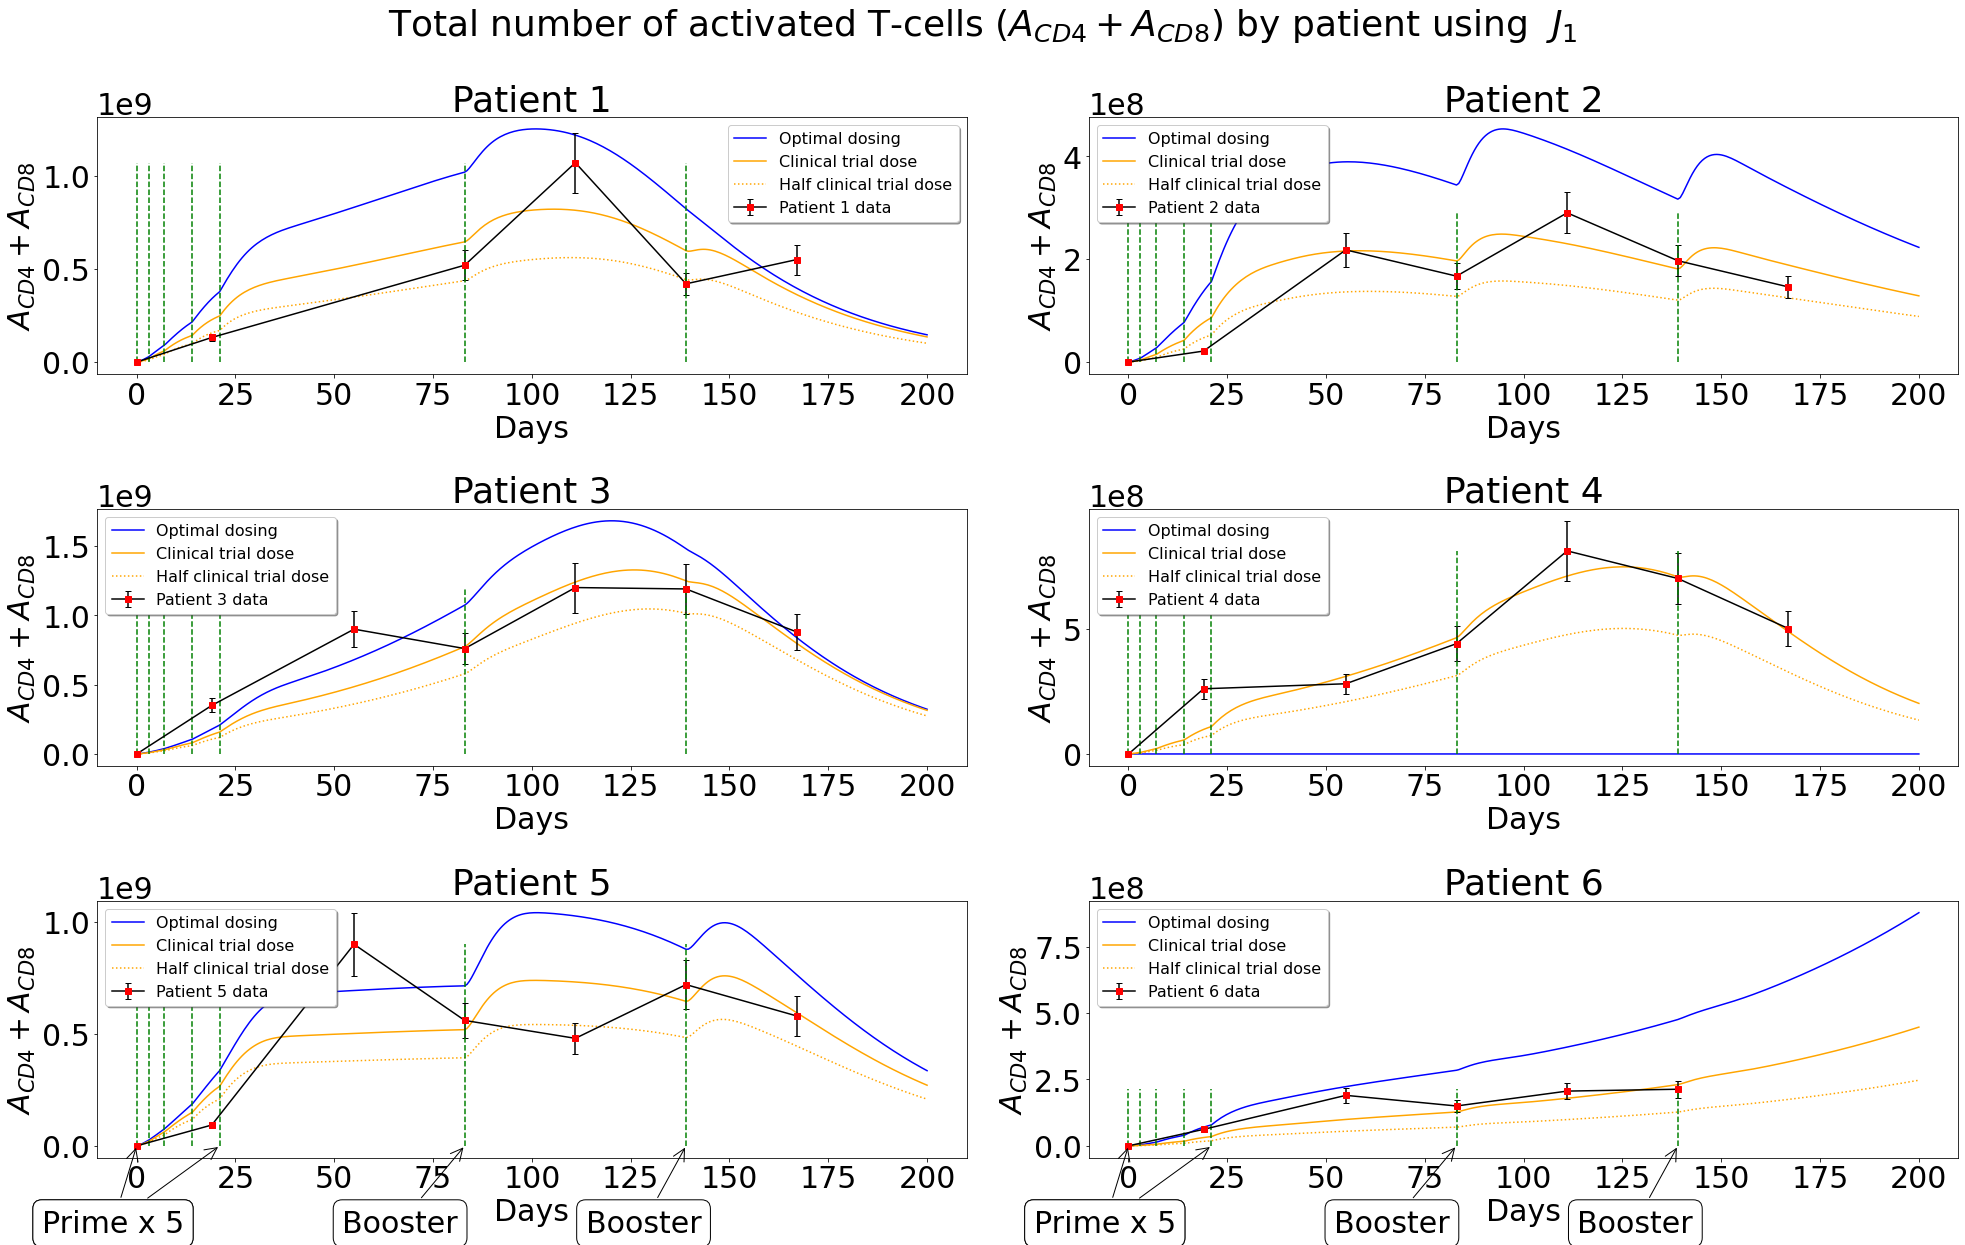

In [17]:
tau = [0,3,7,14,21,83,139]
plt.rcParams.update({'font.size': 30,})
fig, axs = plt.subplots(3, 2,figsize=(28,18))
fig.suptitle('Total number of activated T-cells ($A_{CD4} + A_{CD8}$) by patient using  $J_1$')
for i in range(len(axs.flat)):
    l = len(patients_oc[i+1][1]) 
    t = patients_oc[i+1][0]
    [T, N_CD4, N_CD8, A_CD4, A_CD8] = patients_oc[i+1][1][l-5:l]
    Total_cells = A_CD4 + A_CD8
    [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = patients_max[i+1][1][l-5:l]
    Total_cellsc = A_CD4c + A_CD8c
    [Th, N_CD4h, N_CD8h, A_CD4h, A_CD8h] = patients_half[i+1][1][l-5:l]
    Total_cellsh = A_CD4h + A_CD8h
    if i<4:
        axs.flat[i].set_title('Patient '+str(i+1))
        axs.flat[i].plot(t, Total_cells, color='blue', label = 'Optimal dosing')
        axs.flat[i].plot(t, Total_cellsc, color='orange', label = 'Clinical trial dose')
        axs.flat[i].plot(t, Total_cellsh, linestyle=':',color='orange', label = 'Half clinical trial dose')
        axs.flat[i].errorbar(x=t_data[i], y=patients_data[i]+pest[i], yerr=err[i],
                             label= 'Patient '+ str(i+1)+' data',color = 'black',
                             capsize=3,marker = 's',mfc='red',mec='red')
        axs.flat[i].set_ylabel('$A_{CD4} + A_{CD8}$')
        axs.flat[i].set_xlabel('Days')
        axs.flat[i].legend(loc='best', fancybox=True, shadow=True,fontsize = 16)
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(patients_data[i]+pest[i]), colors= 'g',linestyle = '--')
    else:
        axs.flat[i].set_title('Patient '+str(i+1))
        axs.flat[i].plot(t, Total_cells, color='blue', label = 'Optimal dosing')
        axs.flat[i].plot(t, Total_cellsc, color='orange', label = 'Clinical trial dose')
        axs.flat[i].plot(t, Total_cellsh, linestyle=':',color='orange', label = 'Half clinical trial dose')
        axs.flat[i].errorbar(x=t_data[i], y=patients_data[i]+pest[i], yerr=err[i],
                             label= 'Patient '+ str(i+1)+' data',color = 'black',
                             capsize=3,marker = 's',mfc='red',mec='red')
        axs.flat[i].set_ylabel('$A_{CD4} + A_{CD8}$')
        axs.flat[i].set_xlabel('Days')
        axs.flat[i].legend(loc='best', fancybox=True, shadow=True,fontsize = 16)
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(patients_data[i]+pest[i]), colors= 'g',linestyle = '--')
        axs.flat[i].annotate('Prime x 5', xy=(tau[0], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Prime x 5', xy=(tau[4], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[5], 0 ), xycoords='data',
                             xytext=(tau[5]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[6], 0 ), xycoords='data',
                             xytext=(tau[6]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
fig.tight_layout()

## Total number of activated T-cells ($A_{CD4} + A_{CD8}$) by patient using  $J_2$

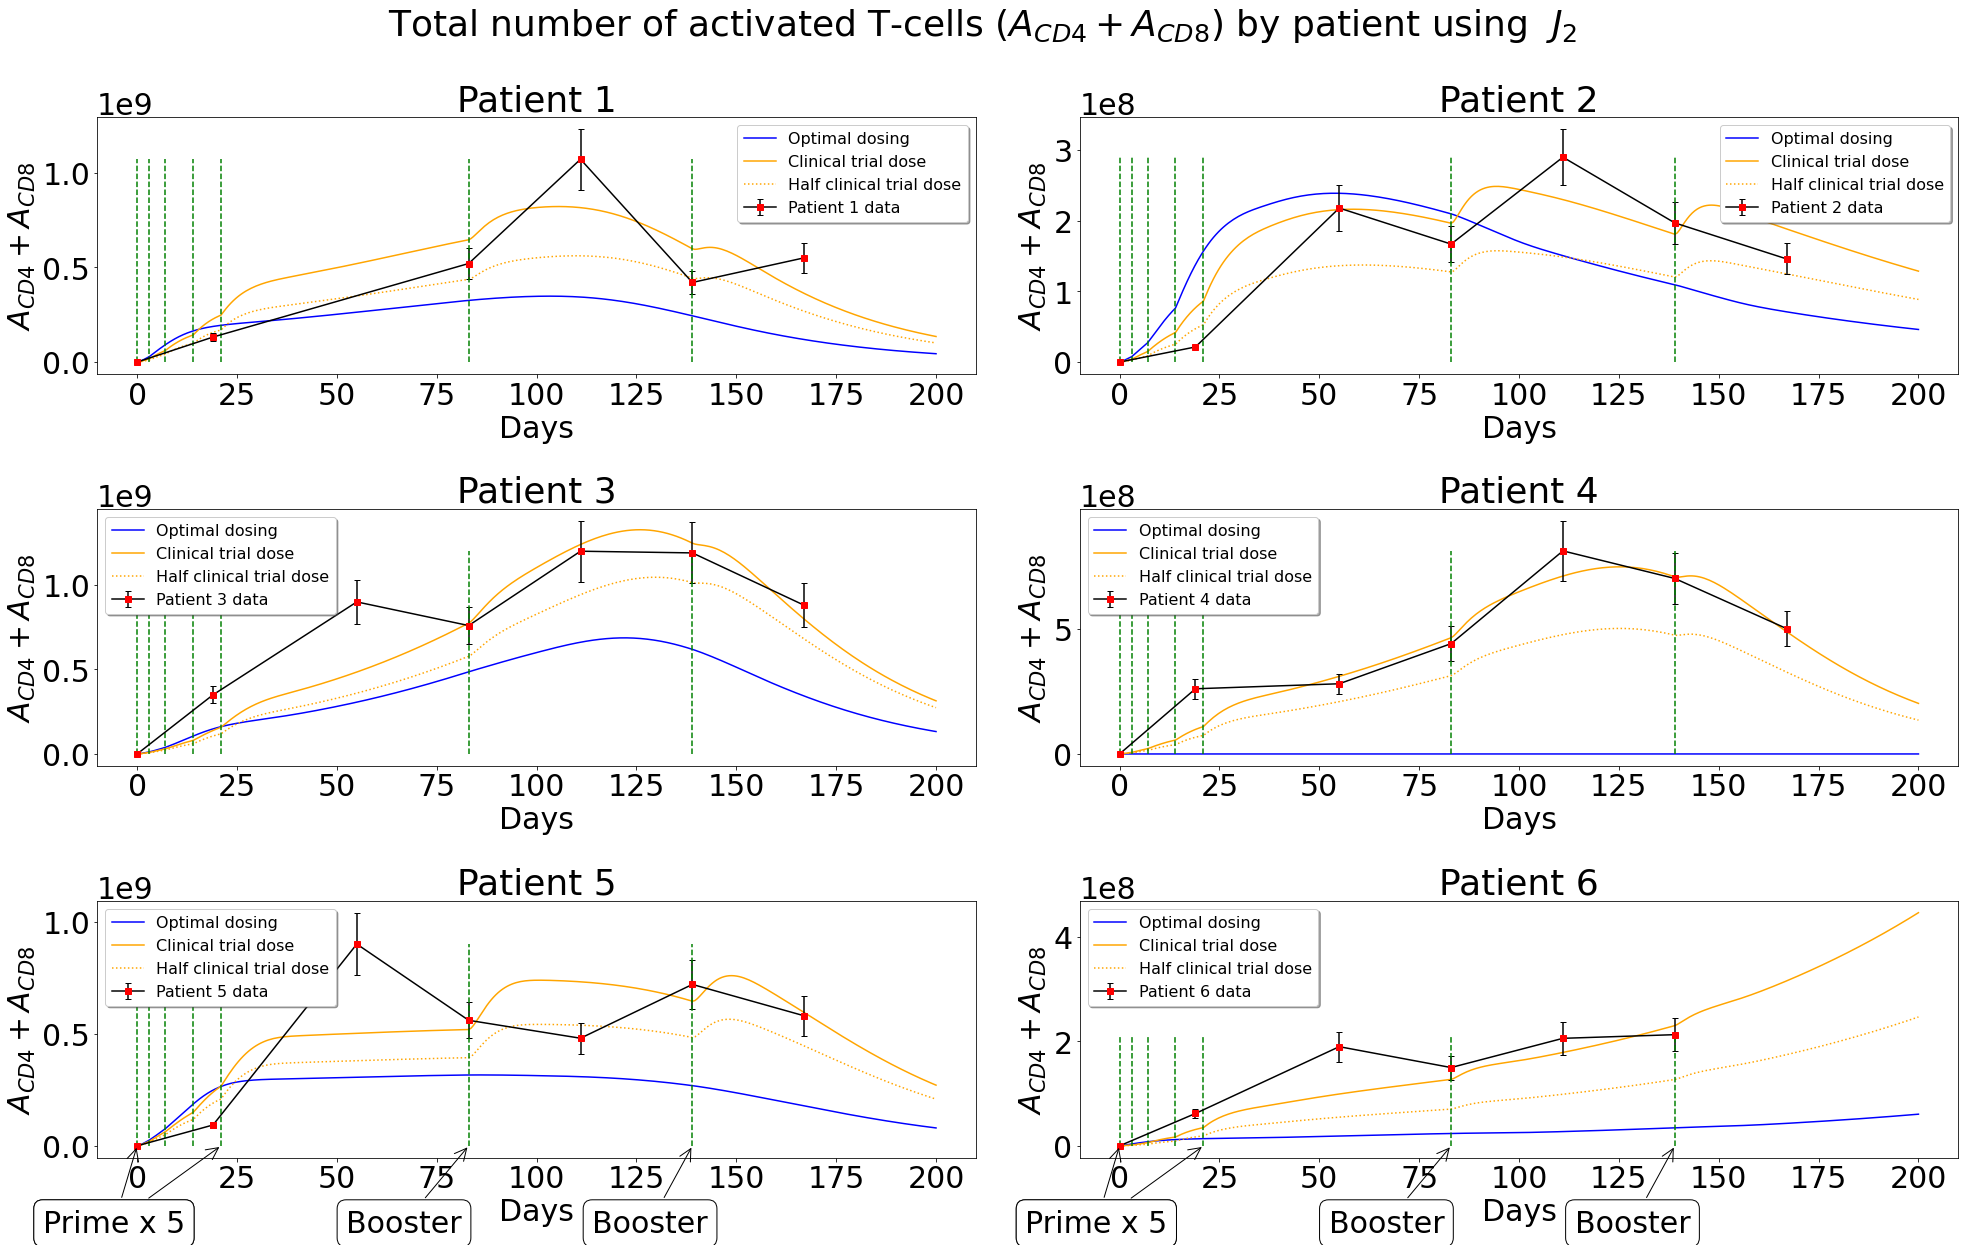

In [22]:
#%% lower bound of peptides close to 0 or 1/2-fold baseline
def y(x):
    if x == 0:
        y = j2patients_oc # 0
    if x == 1:
        y = j2patients_oc1 #1/2
    return y
#%% Choose which patient optimization to plot
opt_patients = y(0) 
# x=0 plots when the lower bound of peptide is 0, this is the case presented in the paper. x=1 is the case in the Suplemental

'Total number of activated T-cells (ACD4+ + ACD8) by patient using J_2'
tau = [0,3,7,14,21,83,139]
plt.rcParams.update({'font.size': 30,})
fig, axs = plt.subplots(3, 2,figsize=(28,18))
fig.suptitle('Total number of activated T-cells ($A_{CD4} + A_{CD8}$) by patient using  $J_2$')
for i in range(len(axs.flat)):
    l = len(opt_patients[i+1][1]) 
    t = opt_patients[i+1][0]
    [T, N_CD4, N_CD8, A_CD4, A_CD8] = opt_patients[i+1][1][l-5:l]
    Total_cells = A_CD4 + A_CD8
    [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = j0patients_max[i+1][1][l-5:l]
    Total_cellsc = A_CD4c + A_CD8c
    [Th, N_CD4h, N_CD8h, A_CD4h, A_CD8h] = j0patients_half[i+1][1][l-5:l]
    Total_cellsh = A_CD4h + A_CD8h
    if i<4:
        axs.flat[i].set_title('Patient '+str(i+1))
        axs.flat[i].plot(t, Total_cells, color='blue', label = 'Optimal dosing')
        axs.flat[i].plot(t, Total_cellsc, color='orange', label = 'Clinical trial dose')
        axs.flat[i].plot(t, Total_cellsh, linestyle=':',color='orange', label = 'Half clinical trial dose')
        axs.flat[i].errorbar(x=t_data[i], y=patients_data[i]+pest[i], yerr=err[i],
                             label= 'Patient '+ str(i+1)+' data',color = 'black',
                             capsize=3,marker = 's',mfc='red',mec='red')
        axs.flat[i].set_ylabel('$A_{CD4} + A_{CD8}$')
        axs.flat[i].set_xlabel('Days')
        axs.flat[i].legend(loc='best', fancybox=True, shadow=True,fontsize = 16)
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(patients_data[i]+pest[i]), colors= 'g',linestyle = '--')
    else:
        axs.flat[i].set_title('Patient '+str(i+1))
        axs.flat[i].plot(t, Total_cells, color='blue', label = 'Optimal dosing')
        axs.flat[i].plot(t, Total_cellsc, color='orange', label = 'Clinical trial dose')
        axs.flat[i].plot(t, Total_cellsh, linestyle=':',color='orange', label = 'Half clinical trial dose')
        axs.flat[i].errorbar(x=t_data[i], y=patients_data[i]+pest[i], yerr=err[i],
                             label= 'Patient '+ str(i+1)+' data',color = 'black',
                             capsize=3,marker = 's',mfc='red',mec='red')
        axs.flat[i].set_ylabel('$A_{CD4} + A_{CD8}$')
        axs.flat[i].set_xlabel('Days')
        axs.flat[i].legend(loc='best', fancybox=True, shadow=True,fontsize = 16)
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(patients_data[i]+pest[i]), colors= 'g',linestyle = '--')
        axs.flat[i].annotate('Prime x 5', xy=(tau[0], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Prime x 5', xy=(tau[4], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[5], 0 ), xycoords='data',
                             xytext=(tau[5]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[6], 0 ), xycoords='data',
                             xytext=(tau[6]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
fig.tight_layout()

#  Diameter of Tumor by patient

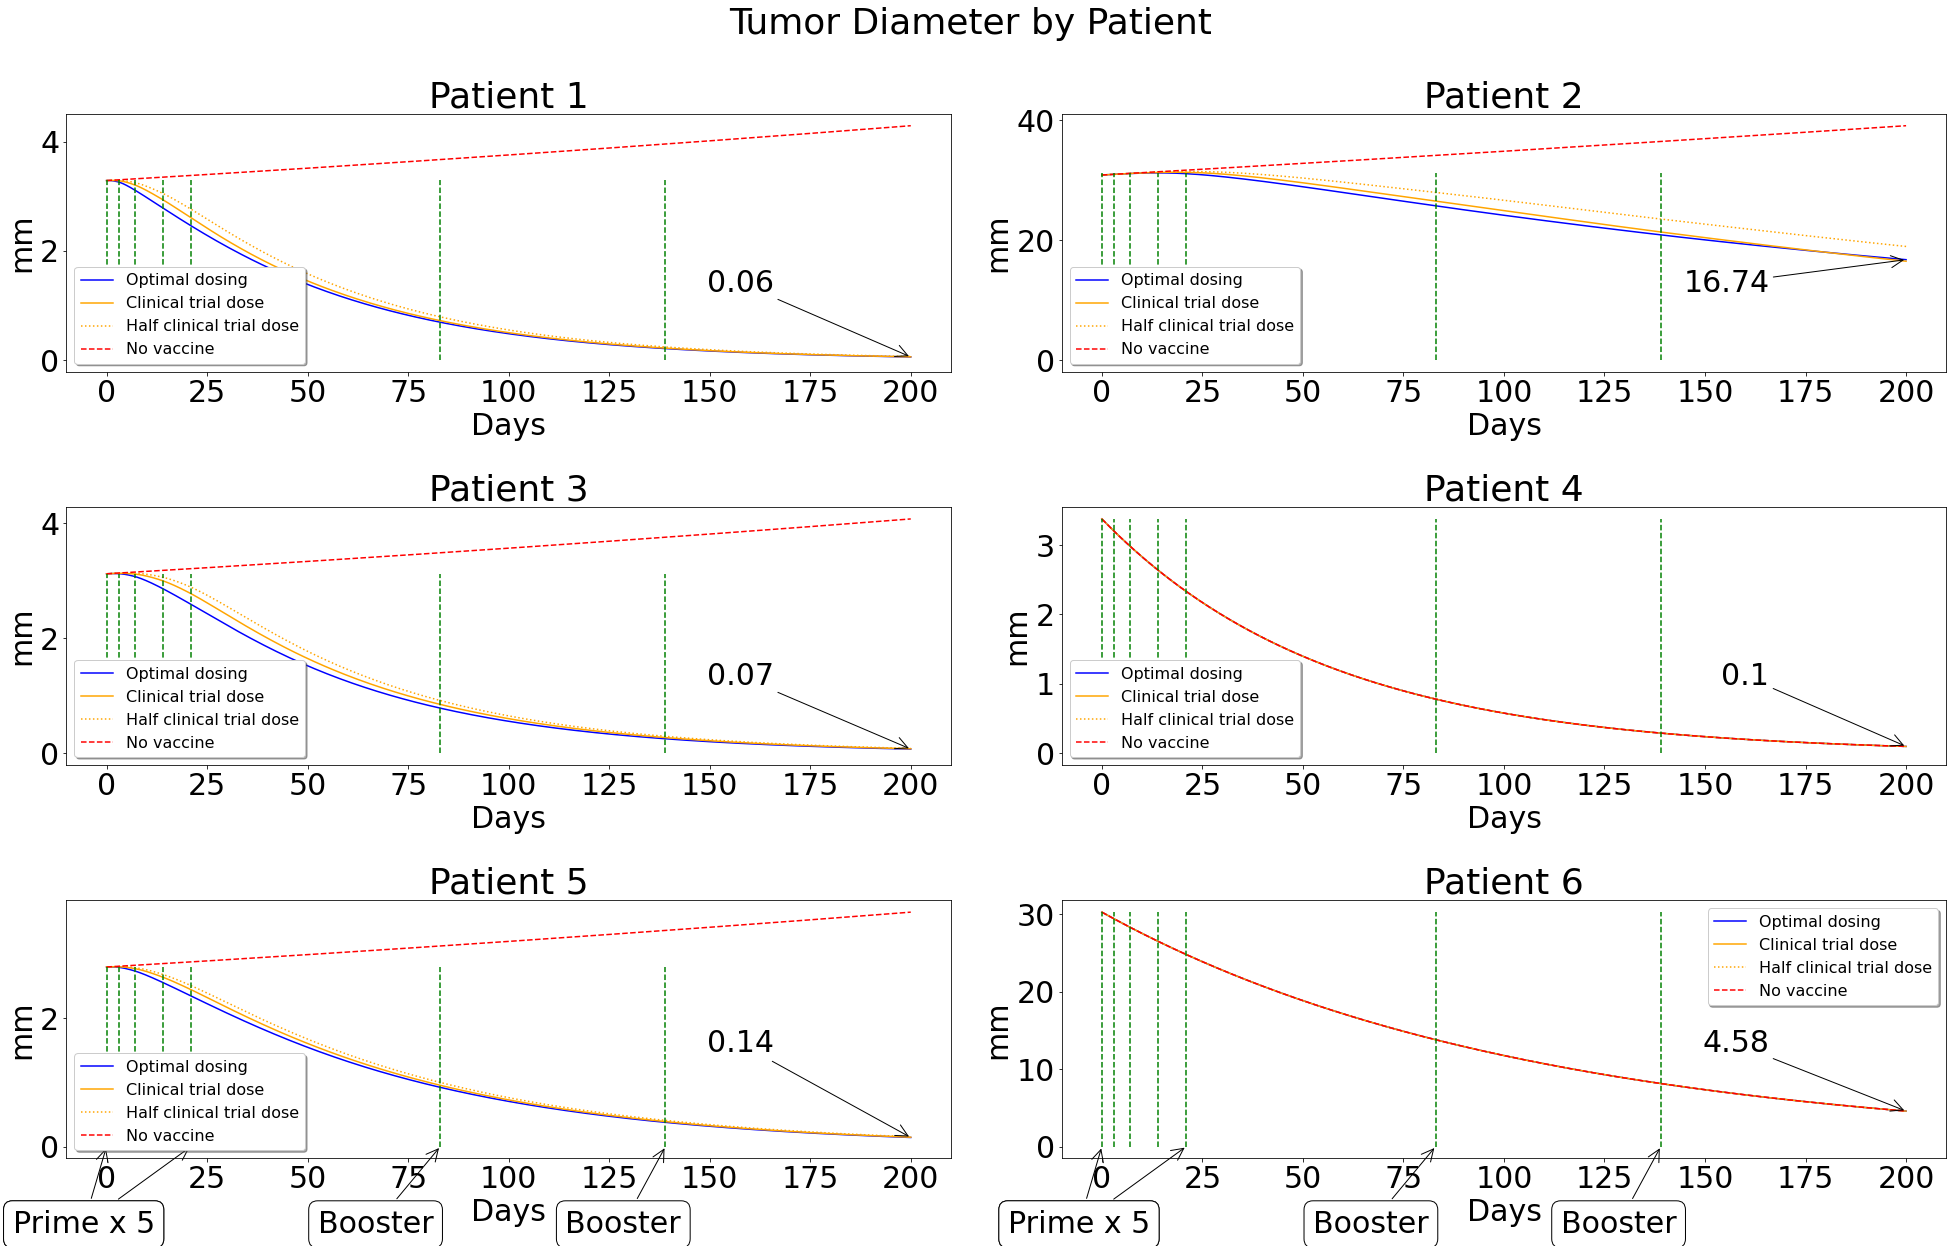

In [25]:
'Tumor Cells to Tumor Diameter'
def diam(cells):
    diam = 2*(((cells*3)/(4*(np.pi)*0.7405*1e5))**(1/3))
    return diam

'Diameter of Tumor by patient'
tau = [0,3,7,14,21,83,139]
plt.rcParams.update({'font.size': 30,})
fig, axs = plt.subplots(3, 2,figsize=(28,18))
fig.suptitle('Tumor Diameter by Patient')
for i in range(len(axs.flat)):
    l = len (opt_patients[i+1][1]) 
    [T, N_CD4, N_CD8, A_CD4, A_CD8] = opt_patients[i+1][1][l-5:l]
    [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = patients_max[i+1][1][l-5:l]
    [Th, N_CD4h, N_CD8h, A_CD4h, A_CD8h] = patients_half[i+1][1][l-5:l]
    [Tn, N_CD4n, N_CD8n, A_CD4n, A_CD8n] = patients_none[i+1][1][l-5:l]
    
    Tdiam = np.zeros(len(T))
    Tcdiam = np.zeros(len(Tc))
    Thdiam = np.zeros(len(Th))
    Tndiam = np.zeros(len(Tn))
    
    for j in range(len(t)):
        Tdiam[j] = diam(T[j])
        Tcdiam[j] = diam(Tc[j])
        Thdiam[j] = diam(Th[j])
        Tndiam[j] = diam(Tn[j])
    
    if i<4:
        axs.flat[i].set_title('Patient '+str(i+1))
        axs.flat[i].plot(t, Tdiam, color = 'blue', label = 'Optimal dosing')
        axs.flat[i].plot(t, Tcdiam, color = 'orange', label = 'Clinical trial dose')
        axs.flat[i].plot(t, Thdiam, linestyle=':' ,color = 'orange', label = 'Half clinical trial dose')
        axs.flat[i].plot(t, Tndiam, linestyle='--',color = 'red', label = 'No vaccine')
        axs.flat[i].set_xlabel('Days')
        axs.flat[i].set_ylabel('mm')
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(Tdiam), colors= 'g',linestyle = '--')
        axs.flat[i].legend(loc='lower left', fancybox=True, shadow=True,fontsize = 16)
        b = str((round(Tdiam[len(t)-1],2)))
        fT = Tdiam[len(t)-1]
        axs.flat[i].annotate(b, xy=(200, fT ), xycoords='data',
                             xytext=(0.8, 0.4), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle='->'),
                             horizontalalignment='right', verticalalignment='top')
        
    else:
        axs.flat[i].set_title('Patient '+str(i+1))
        axs.flat[i].plot(t, Tdiam, color = 'blue', label = 'Optimal dosing')
        axs.flat[i].plot(t, Tcdiam, color = 'orange', label = 'Clinical trial dose')
        axs.flat[i].plot(t, Thdiam, linestyle=':' ,color = 'orange', label = 'Half clinical trial dose')
        axs.flat[i].plot(t, Tndiam, linestyle='--',color = 'red', label = 'No vaccine')
        axs.flat[i].set_xlabel('Days')
        axs.flat[i].set_ylabel('mm')
        axs.flat[i].legend(loc='best', fancybox=True, shadow=True,fontsize = 16)
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(Tdiam), colors= 'g',linestyle = '--')
        b = str((round(Tdiam[len(t)-1],2)))
        fT = Tdiam[len(t)-1]
        axs.flat[i].annotate(b, xy=(200, fT ), xycoords='data',
                             xytext=(0.8, 0.5), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle='->'),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Prime x 5', xy=(tau[0], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Prime x 5', xy=(tau[4], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[5], 0 ), xycoords='data',
                             xytext=(tau[5]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[6], 0 ), xycoords='data',
                             xytext=(tau[6]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
fig.tight_layout()

## Optimal Peptide and Adjuvant Concentrations

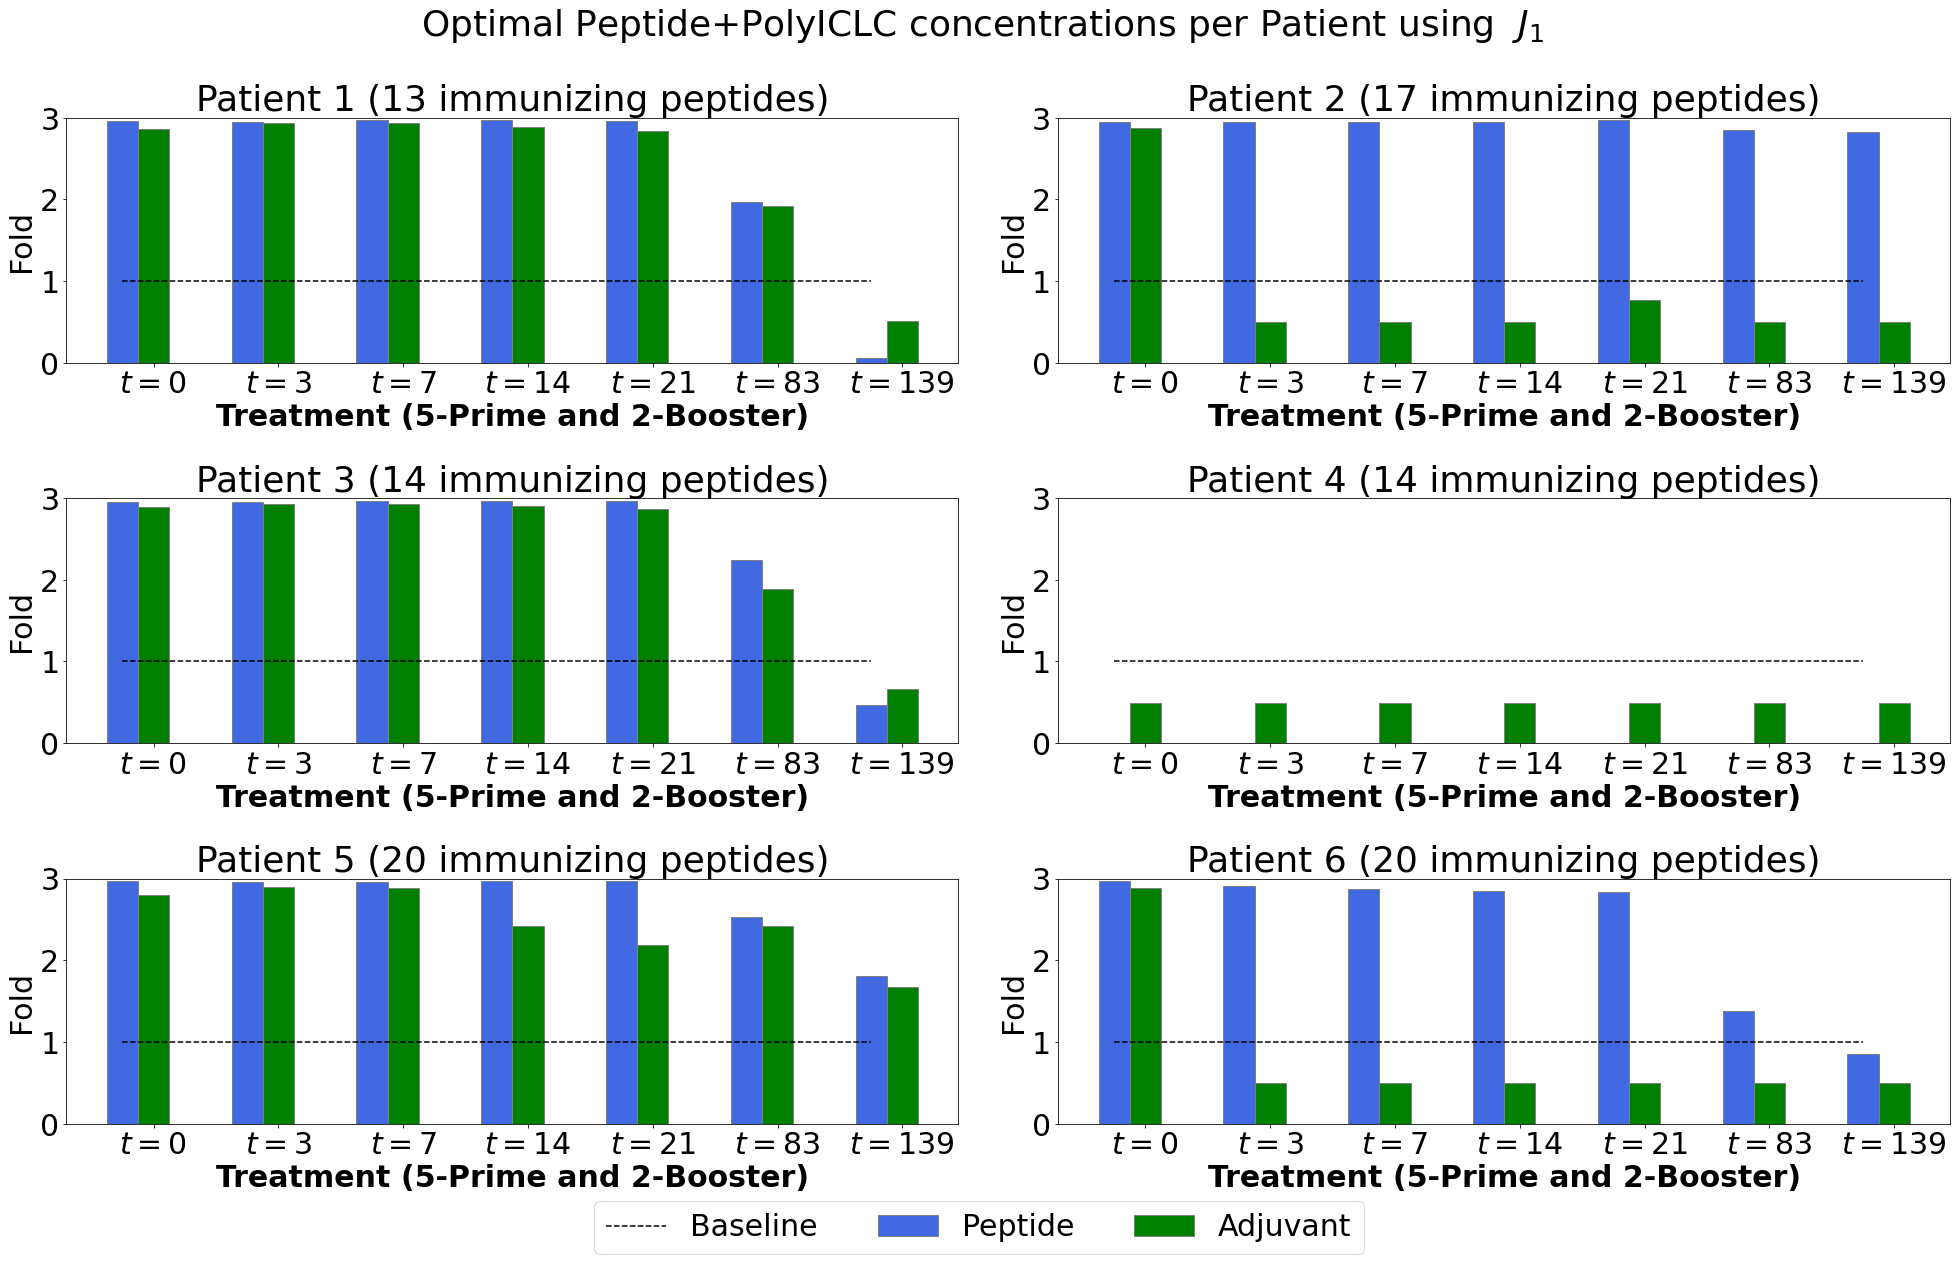

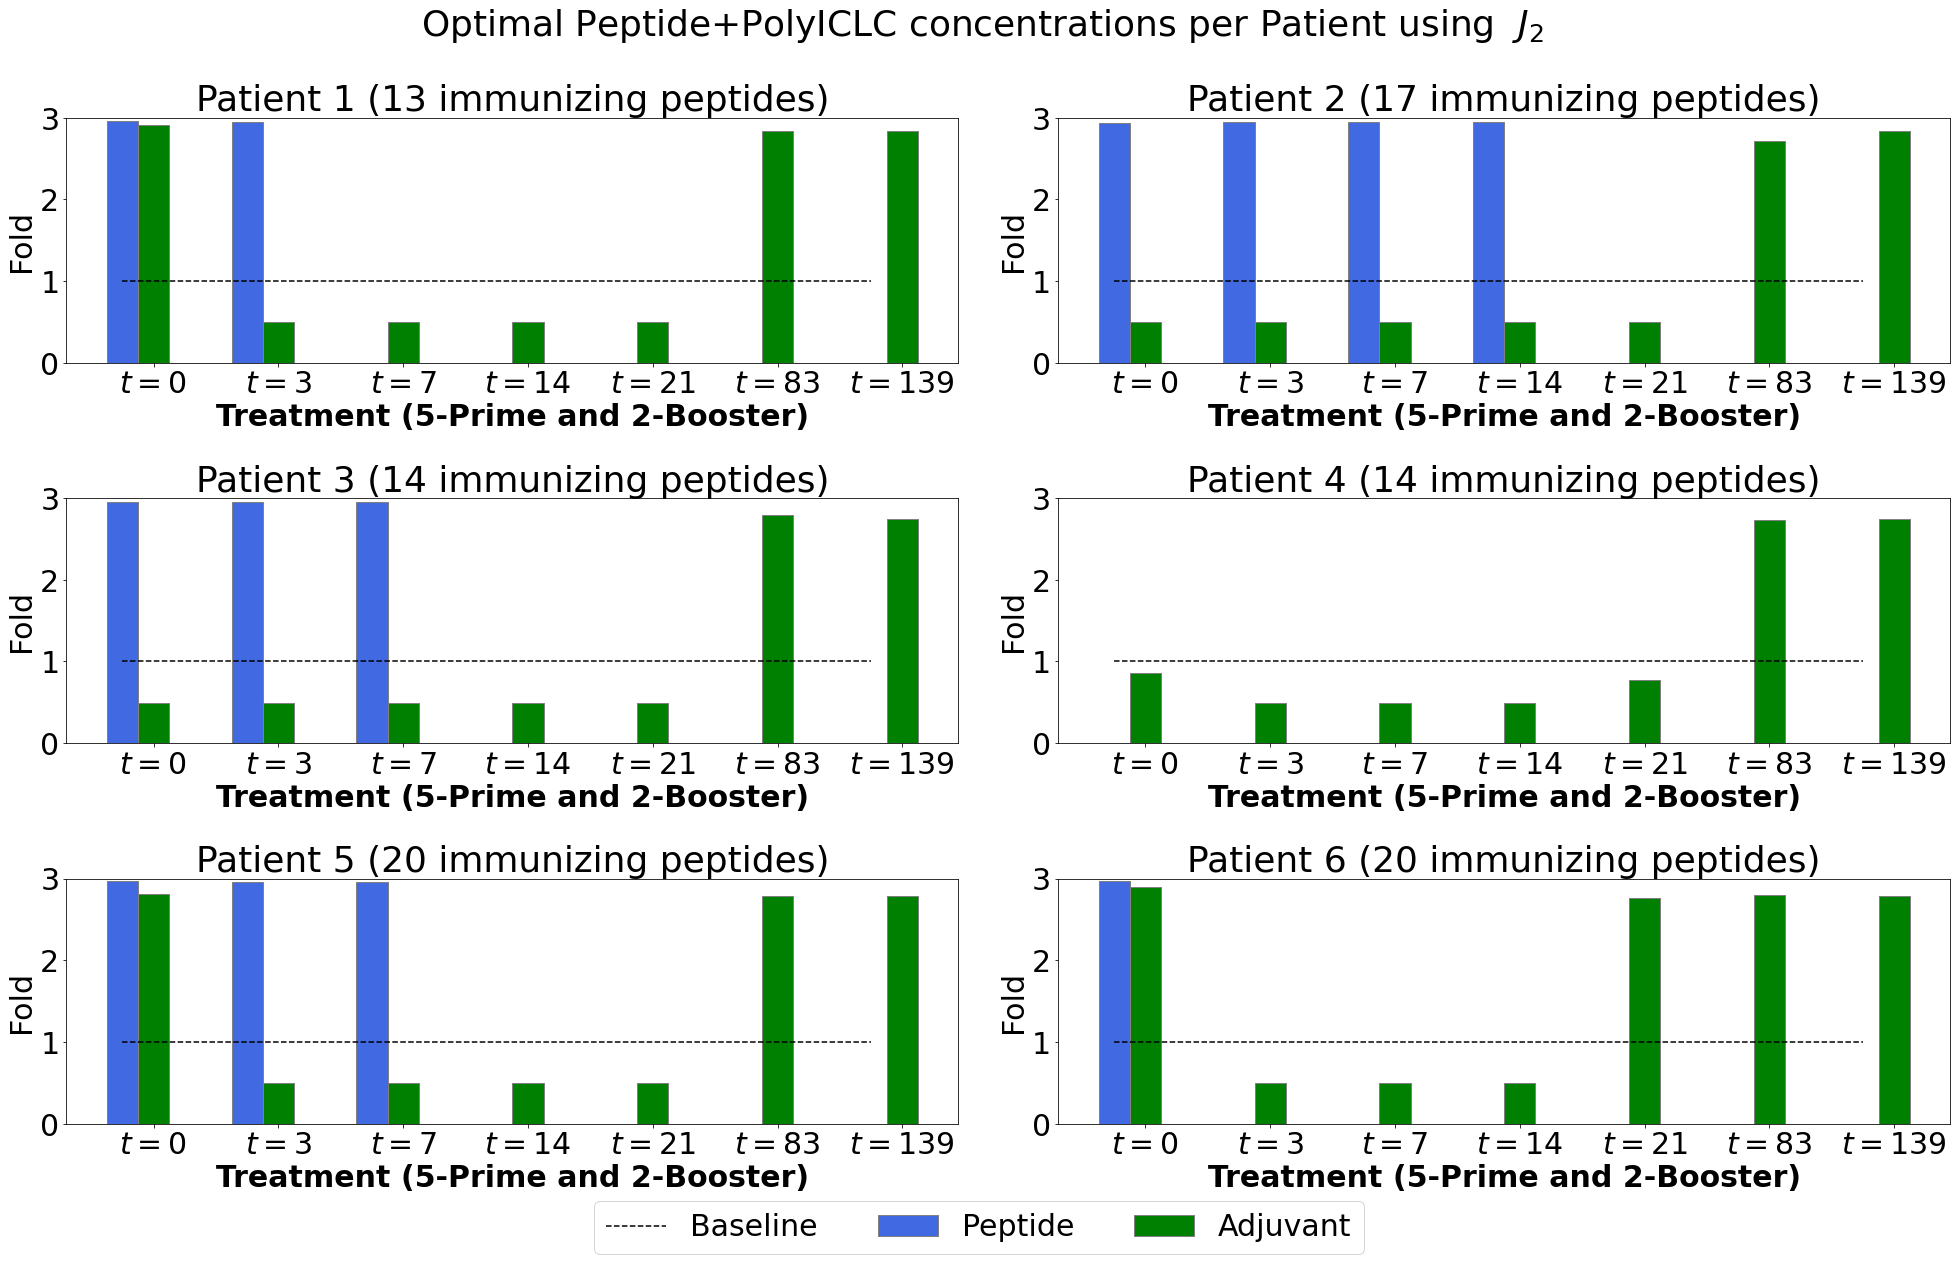

In [51]:
vac_time = 0.001 #Injection rate (20 secs per injection)
rho = 1/vac_time
'Conversion functions from pmol to mg'
def masstomolar(mass,mw):
    'pmol = microgram / molecular weight (KD) '
    molar = (1e6*mass)/mw #'mass -> grams'
    return molar
def molartomass(molar,mw):
    'gram = pmol * molecular weight (KD) /10^6'
    mass = round((molar *mw)/1e6,1)  #'molar -> picomole pmol'
    return mass
#opt_patients = y(0)
max_dose = [3.9,5.1,4.2,4.2,6,6]

'Peptide dose in mg by patient'
peptides = [13,17,14,14,20,20] # number of immunogenic peptides by patient
peptide_mw = [32.68,42.49,38.33,36.03,54.12,53.66] # peptides molecular weight
peptide_dose_j1 = np.zeros((6,len(t)))
peptide_dose_j2 = np.zeros((6,len(t)))
peptide_dosec = np.zeros((6,len(t)))
for i in range(6):
    [t_j1,state_j1,adjoint_j1,control_hp_j1, control_ha_j1,rtime_j1] = patients_oc[i+1]
    [t_j2,state_j2,adjoint_j2,control_hp_j2, control_ha_j2,rtime_j2] = opt_patients[i+1]
    [t,statec,control_hpc, control_hac,rtimec] = patients_max[i+1]
    for j in range(len(t)):
        peptide_dose_j1[i][j] = molartomass(control_hp_j1[j],peptide_mw[i])
        peptide_dose_j2[i][j] = molartomass(control_hp_j2[j],peptide_mw[i])
        peptide_dosec[i][j] = molartomass(control_hpc[j],peptide_mw[i])
        
adjuvant_dose_j1 = np.zeros([6,len(t)])
adjuvant_dose_j2 = np.zeros([6,len(t)])
adjuvant_dosec = np.zeros([6,len(t)])
for i in range(6):
    adjuvant_dose_j1[i] = patients_oc[i+1][4]
    adjuvant_dose_j2[i] = opt_patients[i+1][4]
    adjuvant_dosec[i] = patients_max[i+1][4]
    
peptide_doses_j1 = np.zeros([6,len(tau)])
adjuvant_doses_j1 = np.zeros([6,len(tau)])    
peptide_doses_j2 = np.zeros([6,len(tau)])
adjuvant_doses_j2 = np.zeros([6,len(tau)])
peptide_dosesc = np.zeros([6,len(tau)])
adjuvant_dosesc = np.zeros([6,len(tau)])

for j in range(6):
    for i in range(len(tau)):
        peptide_doses_j1[j][i] = integrate.trapezoid(rho*peptide_dose_j1[j][2*i*100:((2*i+1)*100)-1],
                                                  t_j1[2*i*100:((2*i+1)*100)-1])
        adjuvant_doses_j1[j][i] = integrate.trapezoid((rho*adjuvant_dose_j1[j][2*i*100:((2*i+1)*100)-1])/1000,
                                                  t_j1[2*i*100:((2*i+1)*100)-1])
        peptide_doses_j2[j][i] = integrate.trapezoid(rho*peptide_dose_j2[j][2*i*100:((2*i+1)*100)-1],
                                                  t_j2[2*i*100:((2*i+1)*100)-1])
        adjuvant_doses_j2[j][i] = integrate.trapezoid((rho*adjuvant_dose_j2[j][2*i*100:((2*i+1)*100)-1])/1000,
                                                  t_j2[2*i*100:((2*i+1)*100)-1])
        peptide_dosesc[j][i] = integrate.trapezoid(rho*peptide_dosec[j][2*i*100:((2*i+1)*100)-1],
                                                  t[2*i*100:((2*i+1)*100)-1])
        adjuvant_dosesc[j][i] = integrate.trapezoid((rho*adjuvant_dosec[j][2*i*100:((2*i+1)*100)-1])/1000,
                                                  t[2*i*100:((2*i+1)*100)-1])
        
barWidth = 0.25
max_dose = [3.9,5.1,4.2,4.2,6,6]
plt.rcParams.update({'font.size': 30,})

fig, axs = plt.subplots(3, 2,figsize=(28,18))
plt.suptitle('Optimal Peptide+PolyICLC concentrations per Patient using  $J_1$')
# Set position of bar on X axis
br1 = np.arange(len(tau))
br2 = [x + barWidth for x in br1]
for i in range(len(axs.flat)):
    axs.flat[i].set_title('Patient '+str(i+1)+' ('+str(peptides[i])+' immunizing peptides)')
    axs.flat[i].bar(br1, peptide_doses_j1[i]/max_dose[i] , color ='royalblue', width = barWidth,
            edgecolor ='grey', label ='Peptide')
    axs.flat[i].hlines(y = 1, xmin= 0, xmax = 6, 
                       colors= 'k',linestyle = '--')
    axs.flat[i].bar(br2, adjuvant_doses_j1[i]/2 , color ='g', width = barWidth,
            edgecolor ='grey', label ='Adjuvant')
    axs.flat[i].set_ylim(0,3)
    axs.flat[i].set_xlabel('Treatment (5-Prime and 2-Booster)', fontweight ='bold')
    axs.flat[i].set_ylabel('Fold')
    axs.flat[i].set_xticks([r + barWidth for r in range(len(tau))],
        ['$t=0$ ', '$t=3$', '$t=7$','$t=14$',
         '$t=21$', '$t=83$', '$t=139$' ])
labels = ['Baseline','Peptide','Adjuvant']
fig.legend(labels,loc='lower center',ncol=3) 
fig.tight_layout(rect=(0, .04, 1, 1))

fig, axs = plt.subplots(3, 2,figsize=(28,18))
plt.suptitle('Optimal Peptide+PolyICLC concentrations per Patient using  $J_2$')
# Set position of bar on X axis
br1 = np.arange(len(tau))
br2 = [x + barWidth for x in br1]
for i in range(len(axs.flat)):
    axs.flat[i].set_title('Patient '+str(i+1)+' ('+str(peptides[i])+' immunizing peptides)')
    axs.flat[i].bar(br1, peptide_doses_j2[i]/max_dose[i] , color ='royalblue', width = barWidth,
            edgecolor ='grey', label ='Peptide')
    axs.flat[i].hlines(y = 1, xmin= 0, xmax = 6, 
                       colors= 'k',linestyle = '--')
    axs.flat[i].bar(br2, adjuvant_doses_j2[i]/2 , color ='g', width = barWidth,
            edgecolor ='grey', label ='Adjuvant')
    axs.flat[i].set_ylim(0,3)
    axs.flat[i].set_xlabel('Treatment (5-Prime and 2-Booster)', fontweight ='bold')
    axs.flat[i].set_ylabel('Fold')
    axs.flat[i].set_xticks([r + barWidth for r in range(len(tau))],
        ['$t=0$ ', '$t=3$', '$t=7$','$t=14$',
         '$t=21$', '$t=83$', '$t=139$' ])
labels = ['Baseline','Peptide','Adjuvant'] 
fig.legend(labels,loc='lower center',ncol=3) 
fig.tight_layout(rect=(0, .04, 1, 1))

## Vaccine Dose-Response Curves

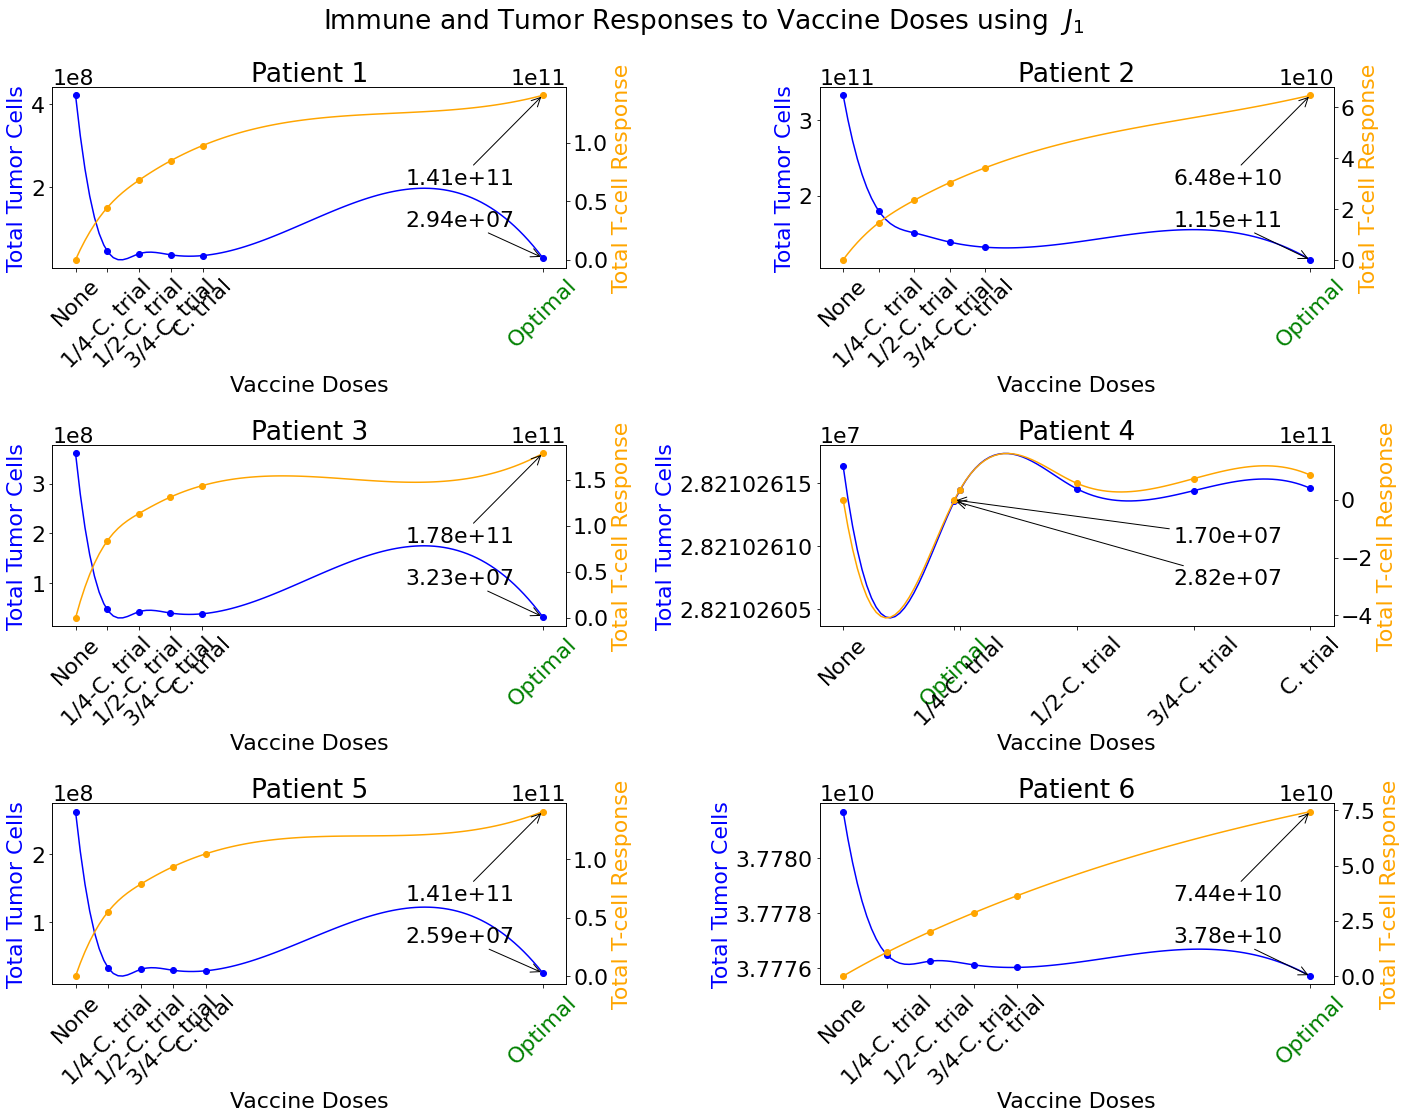

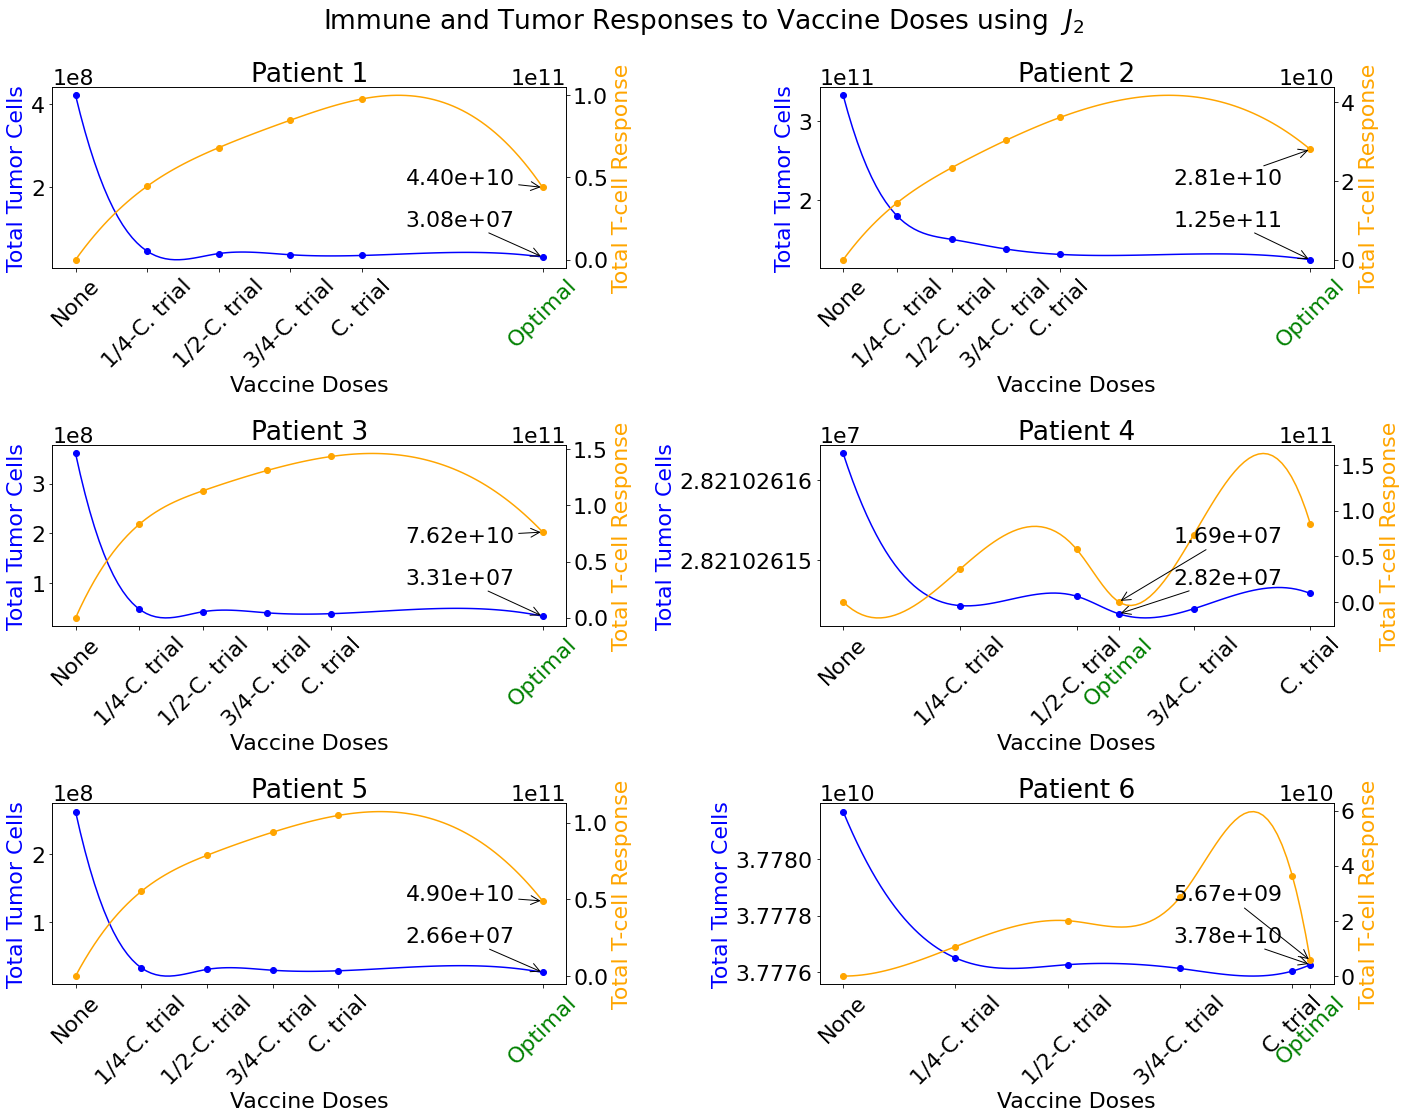

In [52]:
#opt_patients = y(0)
tau = [0,3,7,14,21,83,139]
plt.rcParams.update({'font.size': 22,"axes.formatter.useoffset":False})

fig, axs = plt.subplots(3, 2,figsize=(20,16))
fig.suptitle('Immune and Tumor Responses to Vaccine Doses using  $J_1$')
for i in range(len(axs.flat)):
    patient = i+1
    ax = axs.flat[i]
    l = len(opt_patients[patient][1]) 
    t = opt_patients[patient][0]
    [T, N_CD4, N_CD8, A_CD4, A_CD8] = patients_oc[patient][1][l-5:l]
    Total_cells = A_CD4 + A_CD8
    [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = patients_max[patient][1][l-5:l]
    Total_cellsc = A_CD4c + A_CD8c
    [Tq3, N_CD4q3, N_CD8q3, A_CD4q3, A_CD8q3] = patients_3quarter[patient][1][l-5:l]
    Total_cellsq3 = A_CD4q3 + A_CD8q3
    [Th, N_CD4h, N_CD8h, A_CD4h, A_CD8h] = patients_half[patient][1][l-5:l]
    Total_cellsh = A_CD4h + A_CD8h
    [Tq, N_CD4q, N_CD8q, A_CD4q, A_CD8q] = patients_quarter[patient][1][l-5:l]
    Total_cellsq = A_CD4q + A_CD8q
    [Tn, N_CD4n, N_CD8n, A_CD4n, A_CD8n] = patients_none[patient][1][l-5:l] 
    Total_cellsn = A_CD4n + A_CD8n
    
    Total_tumors = np.array([integrate.trapezoid(T,t),
                             integrate.trapezoid(Tc,t),
                             integrate.trapezoid(Tq3,t),
                             integrate.trapezoid(Th,t),
                             integrate.trapezoid(Tq,t),
                             integrate.trapezoid(Tn,t)])
    Total_Tcells = np.array([integrate.trapezoid(Total_cells,t),
                             integrate.trapezoid(Total_cellsc,t),
                             integrate.trapezoid(Total_cellsq3,t),
                             integrate.trapezoid(Total_cellsh,t),
                             integrate.trapezoid(Total_cellsq,t),
                             integrate.trapezoid(Total_cellsn,t)])
    Total_vaccine = sum(peptide_doses_j1[patient-1])+sum(adjuvant_doses_j1[patient-1])        
    Total_vaccinec = sum(peptide_dosesc[patient-1])+sum(adjuvant_dosesc[patient-1])        
    Total_vaccineq3 = 3*Total_vaccinec/4
    Total_vaccineh = Total_vaccinec/2
    Total_vaccineq = Total_vaccinec/4
    Vaccine_dose = np.array([Total_vaccine,Total_vaccinec, Total_vaccineq3,
                             Total_vaccineh,Total_vaccineq,0])/max(Total_vaccine,Total_vaccinec)
    vspan = np.linspace(min(Vaccine_dose),max(Vaccine_dose),100)
    Tumor_response = interp1d(Vaccine_dose, Total_tumors, kind='cubic', fill_value='extrapolate') 
    Tcell_response = interp1d(Vaccine_dose, Total_Tcells, kind='cubic', fill_value='extrapolate') 
    ax.set_title('Patient '+ str(patient))
    ax.plot(Vaccine_dose, Total_tumors,'o',color = 'blue')
    ax.plot(vspan, Tumor_response(vspan),color = 'blue', label = 'Tumor Response')
    ax.set_ylabel('Total Tumor Cells',color = 'blue')
    ax.set_xticks(ticks=Vaccine_dose)
    ax.set_xticklabels(labels=['Optimal','C. trial','3/4-C. trial','1/2-C. trial',
                               '1/4-C. trial','None'],rotation = 45)
    ax.get_xticklabels()[0].set_color("green")
    ax.set_xlabel('Vaccine Doses')
    b = str('{:.2e}'.format(round(Total_tumors[0],0)))
    fT = Total_tumors[0]
    ax.annotate(b, xy=(Vaccine_dose[0], fT ), xycoords='data',
                         xytext=(0.9, 0.32), textcoords='axes fraction',
                         arrowprops=dict(arrowstyle='->'),
                         horizontalalignment='right', verticalalignment='top')
    ax2= ax.twinx()
    ax2.plot(Vaccine_dose, Total_Tcells,'o' ,color = 'orange')
    ax2.plot(vspan, Tcell_response(vspan), color = 'orange', label = 'T-cell Response')
    ax2.set_ylabel('Total T-cell Response',color = 'orange')
    ax2.set_xlabel('Drug Concentration')
    b = str('{:.2e}'.format(round(Total_Tcells[0],0)))
    fT = Total_Tcells[0]
    ax2.annotate(b, xy=(Vaccine_dose[0], fT ), xycoords='data',
                         xytext=(0.9, 0.55), textcoords='axes fraction',
                         arrowprops=dict(arrowstyle='->'),
                         horizontalalignment='right', verticalalignment='top')
    
    #ax2.legend(loc='best', fancybox=True, shadow=True,fontsize = 14)
    fig.tight_layout()
    
fig, axs = plt.subplots(3, 2,figsize=(20,16))
fig.suptitle('Immune and Tumor Responses to Vaccine Doses using  $J_2$')
for i in range(len(axs.flat)):
    patient = i+1
    ax = axs.flat[i]
    l = len(opt_patients[patient][1]) 
    t = opt_patients[patient][0]
    [T, N_CD4, N_CD8, A_CD4, A_CD8] = opt_patients[patient][1][l-5:l]
    Total_cells = A_CD4 + A_CD8
    [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = patients_max[patient][1][l-5:l]
    Total_cellsc = A_CD4c + A_CD8c
    [Tq3, N_CD4q3, N_CD8q3, A_CD4q3, A_CD8q3] = patients_3quarter[patient][1][l-5:l]
    Total_cellsq3 = A_CD4q3 + A_CD8q3
    [Th, N_CD4h, N_CD8h, A_CD4h, A_CD8h] = patients_half[patient][1][l-5:l]
    Total_cellsh = A_CD4h + A_CD8h
    [Tq, N_CD4q, N_CD8q, A_CD4q, A_CD8q] = patients_quarter[patient][1][l-5:l]
    Total_cellsq = A_CD4q + A_CD8q
    [Tn, N_CD4n, N_CD8n, A_CD4n, A_CD8n] = patients_none[patient][1][l-5:l] 
    Total_cellsn = A_CD4n + A_CD8n
    
    Total_tumors = np.array([integrate.trapezoid(T,t),
                             integrate.trapezoid(Tc,t),
                             integrate.trapezoid(Tq3,t),
                             integrate.trapezoid(Th,t),
                             integrate.trapezoid(Tq,t),
                             integrate.trapezoid(Tn,t)])
    Total_Tcells = np.array([integrate.trapezoid(Total_cells,t),
                             integrate.trapezoid(Total_cellsc,t),
                             integrate.trapezoid(Total_cellsq3,t),
                             integrate.trapezoid(Total_cellsh,t),
                             integrate.trapezoid(Total_cellsq,t),
                             integrate.trapezoid(Total_cellsn,t)])
    Total_vaccine = sum(peptide_doses_j2[patient-1])+sum(adjuvant_doses_j2[patient-1])        
    Total_vaccinec = sum(peptide_dosesc[patient-1])+sum(adjuvant_dosesc[patient-1])        
    Total_vaccineq3 = 3*Total_vaccinec/4
    Total_vaccineh = Total_vaccinec/2
    Total_vaccineq = Total_vaccinec/4
    Vaccine_dose = np.array([Total_vaccine,Total_vaccinec, Total_vaccineq3,
                             Total_vaccineh,Total_vaccineq,0])/max(Total_vaccine,Total_vaccinec)
    vspan = np.linspace(min(Vaccine_dose),max(Vaccine_dose),100)
    Tumor_response = interp1d(Vaccine_dose, Total_tumors, kind='cubic', fill_value='extrapolate') 
    Tcell_response = interp1d(Vaccine_dose, Total_Tcells, kind='cubic', fill_value='extrapolate') 
    ax.set_title('Patient '+ str(patient))
    ax.plot(Vaccine_dose, Total_tumors,'o',color = 'blue')
    ax.plot(vspan, Tumor_response(vspan),color = 'blue', label = 'Tumor Response')
    ax.set_ylabel('Total Tumor Cells',color = 'blue')
    ax.set_xticks(ticks=Vaccine_dose)
    ax.set_xticklabels(labels=['Optimal','C. trial','3/4-C. trial','1/2-C. trial',
                               '1/4-C. trial','None'],rotation = 45)
    ax.get_xticklabels()[0].set_color("green")
    ax.set_xlabel('Vaccine Doses')
    b = str('{:.2e}'.format(round(Total_tumors[0],0)))
    fT = Total_tumors[0]
    ax.annotate(b, xy=(Vaccine_dose[0], fT ), xycoords='data',
                         xytext=(0.9, 0.32), textcoords='axes fraction',
                         arrowprops=dict(arrowstyle='->'),
                         horizontalalignment='right', verticalalignment='top')
    ax2= ax.twinx()
    ax2.plot(Vaccine_dose, Total_Tcells,'o' ,color = 'orange')
    ax2.plot(vspan, Tcell_response(vspan), color = 'orange', label = 'T-cell Response')
    ax2.set_ylabel('Total T-cell Response',color = 'orange')
    ax2.set_xlabel('Drug Concentration')
    b = str('{:.2e}'.format(round(Total_Tcells[0],0)))
    fT = Total_Tcells[0]
    ax2.annotate(b, xy=(Vaccine_dose[0], fT ), xycoords='data',
                         xytext=(0.9, 0.55), textcoords='axes fraction',
                         arrowprops=dict(arrowstyle='->'),
                         horizontalalignment='right', verticalalignment='top')
    
    #ax2.legend(loc='best', fancybox=True, shadow=True,fontsize = 14)
    fig.tight_layout()
    